# NaiveBayes_LogisticRegression_kNearestNeighbors
  ## Beta-Binomial Naive Bayes Classifier Full Implementation
  ## Gaussian Naive Bayes Classifier Full Implementation
  ## Logistic Regression(BP + Newton's Method Update) Full Implementation
  ## K-Nearest Neighbours Classifier Full Implementation

In [1]:
# Python imports
import numpy as np # Matrix and vector computation package
import matplotlib.pyplot as plt  # Plotting library
import time
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator
np.random.seed(seed=1)
from sklearn import metrics # data and evaluation utils
from matplotlib.colors import colorConverter, ListedColormap # some plotting functions
import scipy.io

In [2]:
EMAIL_DATASET_DICT = scipy.io.loadmat('spamData.mat')
X_TRAIN = np.array(EMAIL_DATASET_DICT["Xtrain"])
T_TRAIN = np.array(EMAIL_DATASET_DICT["ytrain"])
T_TRAIN = T_TRAIN.reshape(T_TRAIN.shape[0])
X_TEST = np.array(EMAIL_DATASET_DICT["Xtest"])
T_TEST = np.array(EMAIL_DATASET_DICT["ytest"])
T_TEST = T_TEST.reshape(T_TEST.shape[0])
EMAIL_DATASET = np.column_stack((np.vstack((X_TRAIN, X_TEST)),np.hstack((T_TRAIN, T_TEST))))
print(">>>>>> EMAIL DATASET FEATURE SPACE <<<<<<")
print(">>> FULL <<<")
print(np.array(EMAIL_DATASET).shape)
print(">>> TRAIN <<<")
print(X_TRAIN.shape)
print(T_TRAIN.shape)
print(">>> TEST <<<")
print(X_TEST.shape)
print(T_TEST.shape)

>>>>>> EMAIL DATASET FEATURE SPACE <<<<<<
>>> FULL <<<
(4601, 58)
>>> TRAIN <<<
(3065, 57)
(3065,)
>>> TEST <<<
(1536, 57)
(1536,)


In [3]:
def log_transform(x):
    """Transform x to natural_log(x)."""
    return np.log(x+0.1)

def binary_transform(x):
    """Transform x to binary based on sign."""
    return np.where(x>0, 1, 0)

X_TRAIN_LOG = log_transform(X_TRAIN)
X_TEST_LOG = log_transform(X_TEST)

X_TRAIN_BNY = binary_transform(X_TRAIN)
X_TEST_BNY = binary_transform(X_TEST)

In [4]:
# SHARED HELPER FUNCTIONS FOR METRICS EXTRACTION & CONFUSION TABLE PLOT
def get_accuracy(targets, predictions):
    """Helper Function for calculating the (%) accuracy of 'predictions' compared to 'targets'."""
    return (np.abs(targets - predictions) < 1e-10 ).mean() * 100.0

def get_errors(outputs, targets):
    """Helper Function for calculating the error rates of 'outputs' compared to 'targets'.
       error - overall error rate.
       false_negatives_error - the % of samples wrongly outputed as '0' instead of '1'.
       false_positives_error - the % of samples wrongly outputed as '1' instead of '0'."""
    error_per_sample = []
    error = []
    false_negatives_error = []
    false_positives_error = []
    if(np.array(outputs).ndim == 2):
        for idx, outputs_per_par in enumerate(outputs):
            error_per_sample.append(list(np.array(outputs_per_par) - np.array(targets)))
            error.append(sum(abs(i) for i in error_per_sample[idx])/len(error_per_sample[idx])*100) 
            false_negatives_error.append(abs(sum(i for i in error_per_sample[idx] if i < 0)))
            false_positives_error.append(sum(i for i in error_per_sample[idx] if i > 0))
    elif(np.array(outputs).ndim == 1):
        error_per_sample = (list(np.array(outputs) - np.array(targets)))
        error = (sum(abs(i) for i in error_per_sample)/len(error_per_sample)*100) 
        false_negatives_error = (abs(sum(i for i in error_per_sample if i < 0)))
        false_positives_error = (sum(i for i in error_per_sample if i > 0))
    return error, false_negatives_error, false_positives_error

def get_cost(outputs, targets):
    """Return the cost/error rate at the output."""
    cost_per_sample = []
    cost = []
    if(np.array(outputs).ndim == 2):
        for idx, outputs_per_epoch in enumerate(outputs):
            cost_per_sample.append(list(np.array(outputs_per_epoch) - np.array(targets)))
            cost.append(sum(abs(i) for i in cost_per_sample[idx])/len(cost_per_sample[idx])*100)
    elif(np.array(outputs).ndim == 1):
        cost_per_sample = (list(np.array(outputs) - np.array(targets)))
        cost = (sum(abs(i) for i in cost_per_sample)/len(cost_per_sample)*100)
    return cost

def plot_confusion_table(y_true, y_pred, title):
    """Helper Function for displaying a confusion table of targets vs predictions."""
    # Show confusion table
    conf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=None)  # Get confustion matrix
    # Plot the confusion table
    class_names = ['${:d}$'.format(x) for x in range(0, 2)]  # Binary class names
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Show class labels on each axis
    ax.xaxis.tick_top()
    major_ticks = range(0,2)
    minor_ticks = [x + 0.5 for x in range(0, 2)]
    ax.xaxis.set_ticks(major_ticks, minor=False)
    ax.yaxis.set_ticks(major_ticks, minor=False)
    ax.xaxis.set_ticks(minor_ticks, minor=True)
    ax.yaxis.set_ticks(minor_ticks, minor=True)
    ax.xaxis.set_ticklabels(class_names, minor=False, fontsize=15)
    ax.yaxis.set_ticklabels(class_names, minor=False, fontsize=15)
    # Set plot labels
    ax.yaxis.set_label_position("right")
    ax.set_xlabel('Predicted Label', fontsize=15)
    ax.set_ylabel('True Label', fontsize=15)
    fig.suptitle(title, y=1.03, fontsize=15)
    # Show a grid to seperate digits
    ax.grid(b=True, which=u'minor')
    # Color each grid cell according to the number classes predicted
    ax.imshow(conf_matrix, interpolation='nearest', cmap='binary')
    # Show the number of samples in each cell
    for x in range(conf_matrix.shape[0]):
        for y in range(conf_matrix.shape[1]):
            color = 'w' if x == y else 'k'
            ax.text(x, y, conf_matrix[y,x], ha="center", va="center", color=color)       
    plt.show()

# Q1 Beta-Binomial Naive Bayes Classifier

In [16]:
class BetaBinomialNaiveBayes(object):
    """Beta-binomial naive Bayes classifier implementation."""
    
    def __init__(self, n_features):
        """Initialize the log probability parameters.
        n_features - the number of features per sample."""
        self.C_Prior = np.zeros(2)
        self.C_Cond = np.zeros((2,2,n_features))
        
    def train(self, X_train, T_train, beta_par_1, beta_par_2, beta_prior = False, beta_cond = False):
        """Train the classifier by calculating the log class-prior & class-conditional probabilities.
           X_train - training input samples.
           T_train - training input sample labels.
           beta_par_(1/2) - Beta Prior Distribution hyperparameters.
           beta_prior - is a prior assumed for the class-prior probability.
           beta_cond - is a prior assumed for the class-conditional probability."""
        ############################################
        # Calculating Class Prior Probabilties
        ############################################
        class_1_prior = (T_train.sum() + beta_prior*beta_par_1)/(T_train.shape[0] + beta_prior*(beta_par_1+beta_par_2))
        self.C_Prior[1] = np.log(class_1_prior)
        self.C_Prior[0] = np.log(1-class_1_prior)
        
        #############################################
        # Calculating Class_Conditional Probabilities
        #############################################
    
        #Setting all samples from class 0 to (0)
        tmp = X_train*T_train[:, np.newaxis]
        #Removing all samples from class 0
        tmp = tmp[~np.all(tmp == 0, axis=1)]  
        #Calculating the maximum likelihood of the features to be 1 for class 1
        class_1_1_cond = (np.sum(tmp, axis=0) + beta_cond*beta_par_1)/(tmp.shape[0] + beta_cond*(beta_par_1+beta_par_2))
        #Calculating the log class=1 conditional probabilities
        self.C_Cond[1][1] = np.log(class_1_1_cond)
        self.C_Cond[1][0] = np.log(1-class_1_1_cond)
        
        #Setting all samples from class 1 to (0)
        tmp = X_train*np.logical_not(T_train).astype(int)[:, np.newaxis]
        #Removing all samples from calss 1
        tmp = tmp[~np.all(tmp == 0, axis=1)]
        #Calculating the maximum likelihood of the features to be 1 for class 0
        class_0_1_cond = (np.sum(tmp, axis=0) + beta_cond*beta_par_1)/(tmp.shape[0] + beta_cond*(beta_par_1+beta_par_2))
        #Calculating the log class=0 conditional probabilities
        self.C_Cond[0][1] = np.log(class_0_1_cond)
        self.C_Cond[0][0] = np.log(1-class_0_1_cond)
        
    def predict(self, X_pred):
        """The classifier makes a prediction about the input-samples' labels, based on its model.
            X_pred - input samples."""
        log_prob = []
        #Calculating the probabilities for each sample to be of class 0
        log_prob.append(self.C_Prior[0] + X_pred.dot(self.C_Cond[0][1]) + np.logical_not(X_pred).astype(int).dot(self.C_Cond[0][0]))
        #Calculating the probabilities for each sample to be of class 1
        log_prob.append(self.C_Prior[1] + X_pred.dot(self.C_Cond[1][1]) + np.logical_not(X_pred).astype(int).dot(self.C_Cond[1][0]))
        return np.argmax(log_prob, axis=0)

In [17]:
def fit_beta_classifier(classifier, X_train, T_train, X_test, T_test):
    """Function which performs classifier training, prediction and data gathering.
       classifier - a BetaBinomialNaiveBayes classifier object.
       INPUTS:
         X_train - train dataset samples.
         T_train - train dataset targets.
         X_test - test dataset samples.
         T_train - test dataset targets.
       OUTPUTS:
         for train, test:
           outputs - 2-D prediction matrix with all samples's predicted labels for all beta distributions.
           error - 1-D error rates matrix for each beta distribution.
           false_negative/positive - 1-D matrices for each beta distribution.
           accuracy - 1-D accuracy matrix for each beta distribution.
         t_time - time for performing the fit."""
    outputs_train = []
    outputs_test = []
    accuracy_train = []
    accuracy_test = []

    start_time = time.time()
    # Fit for all beta distributions
    for beta_1, beta_2 in zip(beta_par_1, beta_par_2):
        print("Classifier with Beta({},{})".format(beta_1, beta_2))
        #Train
        classifier.train(X_train, T_train, beta_1, beta_2, beta_prior, beta_cond)
        #Predict Train
        outputs_train.append(classifier.predict(X_train).reshape(X_train.shape[0]))
        accuracy_train.append(get_accuracy(T_train, outputs_train[-1]))
        #Predict Test
        outputs_test.append(classifier.predict(X_test).reshape(X_test.shape[0]))
        accuracy_test.append(get_accuracy(T_test, outputs_test[-1]))
    
    end_time = time.time()
    t_time = end_time - start_time
    error_train, false_negatives_error_train, false_positives_error_train = get_errors(outputs_train, T_train)
    error_test, false_negatives_error_test, false_positives_error_test = get_errors(outputs_test, T_test)
    return classifier, outputs_train, outputs_test, error_train, error_test, false_negatives_error_train, false_negatives_error_test, false_positives_error_train, false_positives_error_test, accuracy_train, accuracy_test, t_time
   
def show_results_beta(outputs_train, outputs_test, T_train, T_test, beta_par, error_train, error_test, false_negatives_error_train, false_negatives_error_test, false_positives_error_train, false_positives_error_test, accuracy_train, accuracy_test, t_time):
    """Helper Function for displaying all data gathered from the fit."""
    #PLOT TRAIN FALSE CLASSIFICATION
    width = 0.35       # the width of the bars
    p1 = plt.bar(beta_par, np.array(false_negatives_error_train)/T_train.shape[0]*100, width, color=(0.2588,0.4433,1.0))
    p2 = plt.bar(beta_par, np.array(false_positives_error_train)/T_train.shape[0]*100, width, color=(1.0,0.5,0.62),
             bottom=np.array(false_negatives_error_train)/T_train.shape[0]*100)

    plt.ylabel('Rate (%)', fontsize=15)
    plt.xlabel('Beta(a,a) Hyperparameter', fontsize=15)
    plt.title('False Train Negatives/Postives Per Beta Distribution')
    plt.yticks(np.arange(0, 51, 5))
    plt.legend((p1[0], p2[0]), ('False Train Negatives', 'False Train Positives'))
    plt.show()
    
    #PLOT TEST FALSE CLASSIFICATION
    width = 0.35       # the width of the bars
    p1 = plt.bar(beta_par, np.array(false_negatives_error_test)/T_test.shape[0]*100, width, color=(0.2588,0.4433,1.0))
    p2 = plt.bar(beta_par, np.array(false_positives_error_test)/T_test.shape[0]*100, width, color=(1.0,0.5,0.62),
             bottom=np.array(false_negatives_error_test)/T_test.shape[0]*100)

    plt.ylabel('Rate (%)', fontsize=15)
    plt.xlabel('Beta(a,a) Hyperparameter', fontsize=15)
    plt.title('False Test Negatives/Postives Per Beta Distribution')
    plt.yticks(np.arange(0, 51, 5))
    plt.legend((p1[0], p2[0]), ('False Test Negatives', 'False Test Positives'))
    plt.show()
    
    #PLOT OVERALL ERROR RATE
    plt.figure()
    plt.plot(beta_par, error_train, 'b-', linewidth=2, label='Train Error Rate')
    plt.plot(beta_par, error_test, 'r-', linewidth=2, label='Test Error Rate')
    # Add labels to the plot
    plt.xlabel('Beta(a,a) Hyperparameter', fontsize=15)
    plt.ylabel('Error Rate (%)', fontsize=15)
    plt.title('Train/Test Error Rates Per Beta Distribution')
    plt.legend()
    x1,x2,y1,y2 = plt.axis()
    plt.grid()
    plt.show()
    
    #PLOT ACCURACY
    plt.figure()
    plt.plot(beta_par, accuracy_train, 'b-', linewidth=2, label='Train Accuracy')
    plt.plot(beta_par, accuracy_test, 'r-', linewidth=3, label='Test Accuracy')
    # Add labels to the plot
    plt.xlabel('Beta(a,a) Hyperparameter', fontsize=15)
    plt.ylabel('Accuracy (%)', fontsize=15)
    plt.title('Accuracy Per Beta Distribution')
    plt.legend()
    x1,x2,y1,y2 = plt.axis()
    plt.grid()
    plt.show()
    
    #DISPLAY DATA
    for idx, beta in enumerate(beta_par):
        if beta in (1,10,100):
            print("BAYES CLASSIFIER(Beta({},{}))".format(beta, beta))
            print("TRAIN ACCURACY: {}% | TEST ACCURACY: {}%".format(accuracy_train[idx], accuracy_test[idx]))
            print("TRAIN ERROR RATE: {:.2f}% | TEST ERROR RATE: {:.2f}%".format(error_train[idx], error_test[idx]))
            print("TRAIN FALSE NEGATIVES ERROR RATE: {:.2f}% | TEST FALSE NEGATIVES ERROR RATE: {:.2f}%".format(false_negatives_error_train[idx]*100/T_train.shape[0], false_negatives_error_test[idx]*100/T_test.shape[0]))
            print("TRAIN FALSE POSITIVES ERROR RATE: {:.2f}% | TEST FALSE POSITIVES ERROR RATE: {:.2f}%".format(false_positives_error_train[idx]*100/T_train.shape[0], false_positives_error_test[idx]*100/T_test.shape[0]))
            print("---------------------------------------------------------------------------------------")
    #Print time for experiment
    m, s = divmod(t_time, 60)
    h, m = divmod(m, 60)
    print("OVERALL TIME FOR CLASSIFIER FIT: {}h:{}m:{:.5f}s".format(h,m,s))
    #Display data about the optimal beta
    best_beta_idx = np.argmax(accuracy_test)
    print("==============================================================================================")
    print("BEST PERFORMANCE ACHIEVED FOR: Beta({},{})".format(beta_par_1[best_beta_idx], beta_par_2[best_beta_idx]))
    print("TRAIN ACCURACY: {}% | TEST ACCURACY: {}%".format(accuracy_train[best_beta_idx], accuracy_test[best_beta_idx]))
    print("TRAIN ERROR RATE: {:.2f}% | TEST ERROR RATE: {:.2f}%".format(error_train[best_beta_idx], error_test[best_beta_idx]))
    print("TRAIN FALSE NEGATIVES ERROR RATE: {:.2f}% | TEST FALSE NEGATIVES ERROR RATE: {:.2f}%".format(false_negatives_error_train[best_beta_idx]*100/T_train.shape[0], false_negatives_error_test[best_beta_idx]*100/T_test.shape[0]))
    print("TRAIN FALSE POSITIVES ERROR RATE: {:.2f}% | TEST FALSE POSITIVES ERROR RATE: {:.2f}%".format(false_positives_error_train[best_beta_idx]*100/T_train.shape[0], false_positives_error_test[best_beta_idx]*100/T_test.shape[0]))
    print("==============================================================================================")
    plot_confusion_table(T_train, outputs_train[best_beta_idx], "Optimal Beta({},{}) Train Confusion Table".format(beta_par_1[best_beta_idx], beta_par_2[best_beta_idx]))
    plot_confusion_table(T_test, outputs_test[best_beta_idx], "Optimal Beta({},{}) Test Confusion Table".format(beta_par_1[best_beta_idx], beta_par_2[best_beta_idx]))

In [18]:
# Control Hyperparameters
beta_prior = False
beta_cond = True
beta_par_1 = np.linspace(0,100,num=201)
beta_par_2 = np.linspace(0,100,num=201)

In [19]:
# Define the classifier to be trained
BBNB = BetaBinomialNaiveBayes(X_TRAIN_BNY.shape[1])
# Display Architecture
print('>>>>>> BETA-BINOMIAL NAIVE BAYES ARCHITECTURE <<<<<<')
print('LOG CLASS PRIORS: {}'.format(BBNB.C_Prior.shape))
print("LOG CLASS CONDITIONAL PROBABILITIES: {}".format(BBNB.C_Cond.shape))

>>>>>> BETA-BINOMINAL NAIVE BAYES ARCHITECTURE <<<<<<
LOG CLASS PRIORS: (2,)
LOG CLASS CONDITIONAL PROBABILITIES: (2, 2, 57)


Classifier with Beta(0.0,0.0)
Classifier with Beta(0.5,0.5)
Classifier with Beta(1.0,1.0)
Classifier with Beta(1.5,1.5)
Classifier with Beta(2.0,2.0)
Classifier with Beta(2.5,2.5)
Classifier with Beta(3.0,3.0)
Classifier with Beta(3.5,3.5)
Classifier with Beta(4.0,4.0)
Classifier with Beta(4.5,4.5)
Classifier with Beta(5.0,5.0)
Classifier with Beta(5.5,5.5)
Classifier with Beta(6.0,6.0)
Classifier with Beta(6.5,6.5)
Classifier with Beta(7.0,7.0)
Classifier with Beta(7.5,7.5)
Classifier with Beta(8.0,8.0)
Classifier with Beta(8.5,8.5)
Classifier with Beta(9.0,9.0)
Classifier with Beta(9.5,9.5)
Classifier with Beta(10.0,10.0)
Classifier with Beta(10.5,10.5)
Classifier with Beta(11.0,11.0)

D:\Work\Anaconda\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log
D:\Work\Anaconda\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log



Classifier with Beta(11.5,11.5)
Classifier with Beta(12.0,12.0)
Classifier with Beta(12.5,12.5)
Classifier with Beta(13.0,13.0)
Classifier with Beta(13.5,13.5)
Classifier with Beta(14.0,14.0)
Classifier with Beta(14.5,14.5)
Classifier with Beta(15.0,15.0)
Classifier with Beta(15.5,15.5)
Classifier with Beta(16.0,16.0)
Classifier with Beta(16.5,16.5)
Classifier with Beta(17.0,17.0)
Classifier with Beta(17.5,17.5)
Classifier with Beta(18.0,18.0)
Classifier with Beta(18.5,18.5)
Classifier with Beta(19.0,19.0)
Classifier with Beta(19.5,19.5)
Classifier with Beta(20.0,20.0)
Classifier with Beta(20.5,20.5)
Classifier with Beta(21.0,21.0)
Classifier with Beta(21.5,21.5)
Classifier with Beta(22.0,22.0)
Classifier with Beta(22.5,22.5)
Classifier with Beta(23.0,23.0)
Classifier with Beta(23.5,23.5)
Classifier with Beta(24.0,24.0)
Classifier with Beta(24.5,24.5)
Classifier with Beta(25.0,25.0)
Classifier with Beta(25.5,25.5)
Classifier with Beta(26.0,26.0)
Classifier with Beta(26.5,26.5)
Classif

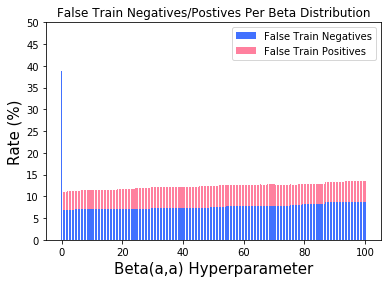

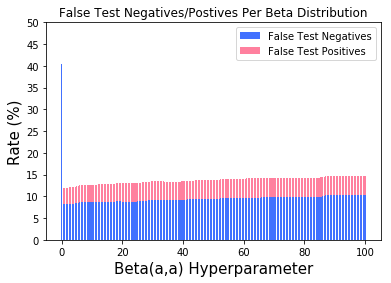

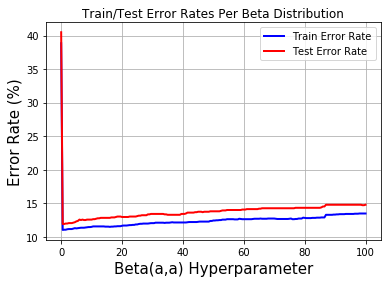

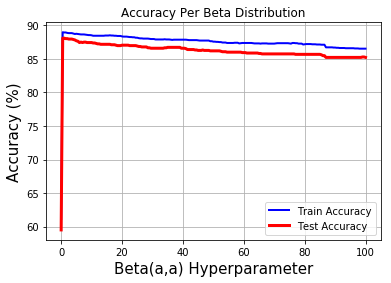

BAYES CLASSIFIER(Beta(1.0,1.0))
TRAIN ACCURACY: 88.93964110929853% | TEST ACCURACY: 88.0859375%
TRAIN ERROR RATE: 11.06% | TEST ERROR RATE: 11.91%
TRAIN FALSE NEGATIVES ERROR RATE: 6.85% | TEST FALSE NEGATIVES ERROR RATE: 8.27%
TRAIN FALSE POSITIVES ERROR RATE: 4.21% | TEST FALSE POSITIVES ERROR RATE: 3.65%
---------------------------------------------------------------------------------------
BAYES CLASSIFIER(Beta(10.0,10.0))
TRAIN ACCURACY: 88.51549755301794% | TEST ACCURACY: 87.43489583333334%
TRAIN ERROR RATE: 11.48% | TEST ERROR RATE: 12.57%
TRAIN FALSE NEGATIVES ERROR RATE: 7.05% | TEST FALSE NEGATIVES ERROR RATE: 8.66%
TRAIN FALSE POSITIVES ERROR RATE: 4.44% | TEST FALSE POSITIVES ERROR RATE: 3.91%
---------------------------------------------------------------------------------------
BAYES CLASSIFIER(Beta(100.0,100.0))
TRAIN ACCURACY: 86.5252854812398% | TEST ACCURACY: 85.22135416666666%
TRAIN ERROR RATE: 13.47% | TEST ERROR RATE: 14.78%
TRAIN FALSE NEGATIVES ERROR RATE: 8.78% 

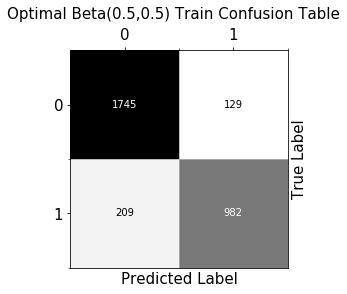

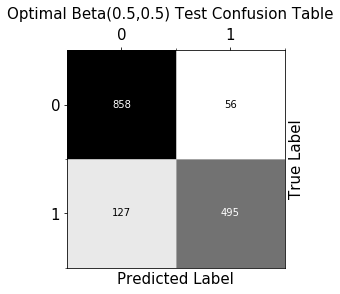

In [20]:
# RUN
BBNB, OUTPUTS_TRAIN, OUTPUTS_TEST, ERROR_TRAIN, ERROR_TEST, FALSE_NEGATIVES_ERROR_TRAIN, FALSE_NEGATIVES_ERROR_TEST, FALSE_POSITIVES_ERROR_TRAIN, FALSE_POSITIVES_ERROR_TEST, ACCURACY_TRAIN, ACCURACY_TEST, T_TIME = fit_beta_classifier(BBNB, X_TRAIN_BNY, T_TRAIN, X_TEST_BNY, T_TEST)
show_results_beta(OUTPUTS_TRAIN, OUTPUTS_TEST, T_TRAIN, T_TEST, beta_par_1, ERROR_TRAIN, ERROR_TEST, FALSE_NEGATIVES_ERROR_TRAIN, FALSE_NEGATIVES_ERROR_TEST, FALSE_POSITIVES_ERROR_TRAIN, FALSE_POSITIVES_ERROR_TEST, ACCURACY_TRAIN, ACCURACY_TEST, T_TIME)

# Q2 Gaussian Naive Bayes Classifier

In [21]:
class GaussianNaiveBayes(object):
    """Gaussian Naive Bayes classifier implementation."""
    
    def __init__(self, n_features):
        """Initialize the log prior & class-cond mean/variance parameters.
        n_features is the number of features per sample."""
        self.C_Prior = np.zeros(2)
        self.C_Mean = np.zeros((2, n_features))
        self.C_Var = np.zeros((2, n_features))
        
    def train(self, X_train, T_train):
        """Train the classifier by calculating the log class-prior & class mean/variance using Maximum Likelihood.
           X_train - training input samples.
           T_train - training input sample labels."""
        ############################################
        # Calculating Class Prior Probabilties
        ############################################
        class_1_prior = T_train.sum()/(T_train.shape[0])
        self.C_Prior[1] = np.log(class_1_prior)
        self.C_Prior[0] = np.log(1-class_1_prior)
        
        ############################################
        # Calculating Class-Conditional Mean & Variance
        ############################################
        #Setting all samples from class 0 to (0)
        tmp = X_train*T_train[:, np.newaxis]
        #Removing all samples from class 0
        tmp = tmp[~np.all(tmp == 0, axis=1)]
        #Maximum Likelihood estimation of the mean and variance of each feature based on all training samples from class 1
        self.C_Mean[1] = np.mean(tmp,axis=0)
        self.C_Var[1] = np.var(tmp,axis=0)
        
        #Setting all samples from class 1 to (0)
        tmp = X_train*np.logical_not(T_train).astype(int)[:, np.newaxis]
        #Removing all samples from calss 1
        tmp = tmp[~np.all(tmp == 0, axis=1)]
        #Maximum Likelihood estimation of the mean and variance of each feature based on all training samples from class 0
        self.C_Mean[0] = np.mean(tmp,axis=0)
        self.C_Var[0] = np.var(tmp,axis=0)      
        
    def calculate_log_probability(self, X_pred):
        """Plug-in estimator of the natural log of the class-conditional probabilities.
           X_pred - input samples."""
        #Calculating the class-conditional probability of the features for class 1
        exponent = np.exp(-((X_pred - self.C_Mean[1])**2 / (2 * self.C_Var[1])))
        #Calculating the log class=1 conditional probabilities
        class_1_log_cond = np.log((1 / (np.sqrt(2 * np.pi * self.C_Var[1]))) * exponent)
        
        #Calculating the class-conditional probability of the features for class 0
        exponent = np.exp(-((X_pred - self.C_Mean[0])**2 / (2 * self.C_Var[0])))
        #Calculating the log class=0 conditional probabilities
        class_0_log_cond = np.log((1 / (np.sqrt(2 * np.pi * self.C_Var[0]))) * exponent)
        return class_0_log_cond, class_1_log_cond
 
    def predict(self, X_pred):
        """The classifier makes a prediction about the inputs samples'labels, based on the trained priors
           and plugged-in input samples.
           X_pred - input samples."""
        log_prob = []
        class_0_log_cond, class_1_log_cond = self.calculate_log_probability(X_pred)
        #Calculating the probabilities for each sample to be of class 0
        log_prob.append(self.C_Prior[0] + np.sum(class_0_log_cond,axis=1))
        #Calculating the probabilities for each sample to be of class 1
        log_prob.append(self.C_Prior[1] + np.sum(class_1_log_cond,axis=1))
        return np.argmax(log_prob, axis=0)

In [22]:
def fit_gaussian_classifier(classifier, X_train, T_train, X_test, T_test):
    """Function which performs classifier training, prediction and data gathering.
       classifier - a GaussianNaiveBayes classifier object.
       INPUTS:
         X_train - train dataset samples.
         T_train - train dataset targets.
         X_test - test dataset samples.
         T_train - test dataset targets.
       OUTPUTS:
         for train, test:
           outputs - 1-D prediction matrix with all samples's predicted labels.
           error - scalar error rate for the fit.
           false_negative/positive - scalar error rates for the fit.
           accuracy - scalar rate for the fit.
         t_time - time for performing the fit."""
    start_time = time.time()
    print("Starting Gaussian Naive Bayes Classifier Fit")
    #Train
    classifier.train(X_train, T_train)
    #Predict train dataset
    outputs_train = classifier.predict(X_train).reshape(X_train.shape[0])
    accuracy_train = get_accuracy(T_train, outputs_train)
    #Predict test dataset
    outputs_test = classifier.predict(X_test).reshape(X_test.shape[0])
    accuracy_test = get_accuracy(T_test, outputs_test)
    
    end_time = time.time()
    t_time = end_time - start_time
    error_train, false_negatives_error_train, false_positives_error_train = get_errors(outputs_train, T_train)
    error_test, false_negatives_error_test, false_positives_error_test = get_errors(outputs_test, T_test)
    return classifier, outputs_train, outputs_test, error_train, error_test, false_negatives_error_train, false_negatives_error_test, false_positives_error_train, false_positives_error_test, accuracy_train, accuracy_test, t_time
    
def show_results_gaussian(outputs_train, outputs_test, T_train, T_test, error_train, error_test, false_negatives_error_train, false_negatives_error_test, false_positives_error_train, false_positives_error_test, accuracy_train, accuracy_test, t_time):
    """Helper Function for displaying all data gathered from the fit."""
    print(">>>>> GAUSSIAN NAIVE BAYES CLASSIFIER <<<<<")
    print("TRAIN ACCURACY: {}% | TEST ACCURACY: {}%".format(accuracy_train, accuracy_test))
    print("TRAIN ERROR RATE: {:.2f}% | TEST ERROR RATE: {:.2f}%".format(error_train, error_test))
    print("TRAIN FALSE NEGATIVES ERROR RATE: {:.2f}% | TEST FALSE NEGATIVES ERROR RATE: {:.2f}%".format(false_negatives_error_train*100/T_train.shape[0], false_negatives_error_test*100/T_test.shape[0]))
    print("TRAIN FALSE POSITIVES ERROR RATE: {:.2f}% | TEST FALSE POSITIVES ERROR RATE: {:.2f}%".format(false_positives_error_train*100/T_train.shape[0], false_positives_error_test*100/T_test.shape[0]))
    #Print time for experiment
    m, s = divmod(t_time, 60)
    h, m = divmod(m, 60)
    print("OVERALL TIME FOR CLASSIFIER FIT: {}h:{}m:{:.5f}s".format(h,m,s))
    plot_confusion_table(T_train, outputs_train, "Gaussian Naive Bayes Train Confusion Table")
    plot_confusion_table(T_test, outputs_test, "Gaussian Naive Bayes Test Confusion Table")

In [25]:
# Define the classifier to be trained
GNB = GaussianNaiveBayes(X_TRAIN_LOG.shape[1])
# Display Architecture
print('>>>>>> GAUSSIAN NAIVE BAYES ARCHITECTURE <<<<<<')
print('LOG CLASS PRIORS: {}'.format(GNB.C_Prior.shape))
print("CLASS-CONDITIONAL MEANS: {}".format(GNB.C_Mean.shape))
print("CLASS-CONDITIONAL VARIANCES: {}".format(GNB.C_Var.shape))

>>>>>> GAUSSIAN NAIVE BAYES ARCHITECTURE <<<<<<
LOG CLASS PRIORS: (2,)
CLASS-CONDITIONAL MEANS: (2, 57)
CLASS-CONDITIONAL VARIANCES: (2, 57)


Starting Gaussian Naive Bayes Classifier Fit
>>>>> GAUSSIAN NAIVE BAYES CLASSIFIER <<<<<
TRAIN ACCURACY: 83.6215334420881% | TEST ACCURACY: 81.8359375%
TRAIN ERROR RATE: 16.38% | TEST ERROR RATE: 18.16%
TRAIN FALSE NEGATIVES ERROR RATE: 1.63% | TEST FALSE NEGATIVES ERROR RATE: 2.73%
TRAIN FALSE POSITIVES ERROR RATE: 14.75% | TEST FALSE POSITIVES ERROR RATE: 15.43%
OVERALL TIME FOR CLASSIFIER FIT: 0.0h:0.0m:0.03800s


D:\Work\Anaconda\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
D:\Work\Anaconda\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log


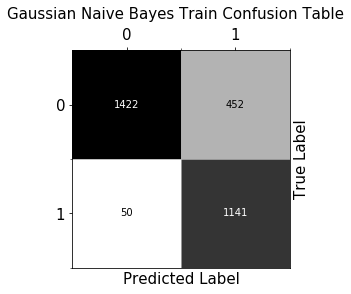

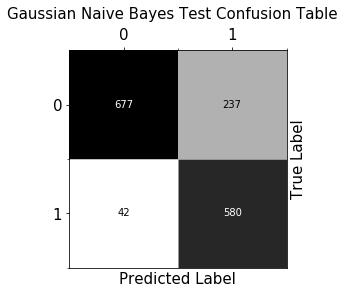

In [26]:
# RUN
GNB, OUTPUTS_TRAIN, OUTPUTS_TEST, ERROR_TRAIN, ERROR_TEST, FALSE_NEGATIVES_ERROR_TRAIN, FALSE_NEGATIVES_ERROR_TEST, FALSE_POSITIVES_ERROR_TRAIN, FALSE_POSITIVES_ERROR_TEST, ACCURACY_TRAIN, ACCURACY_TEST, T_TIME = fit_gaussian_classifier(GNB, X_TRAIN_LOG, T_TRAIN, X_TEST_LOG, T_TEST)
show_results_gaussian(OUTPUTS_TRAIN, OUTPUTS_TEST, T_TRAIN, T_TEST, ERROR_TRAIN, ERROR_TEST, FALSE_NEGATIVES_ERROR_TRAIN, FALSE_NEGATIVES_ERROR_TEST, FALSE_POSITIVES_ERROR_TRAIN, FALSE_POSITIVES_ERROR_TEST, ACCURACY_TRAIN, ACCURACY_TEST, T_TIME)

# Q3 Logistic Regression

In [5]:
def logistic(z):
    """Logistic/Sigmoid/Squashing function. Can take scalars and matrices."""
    return 1 / (1 + np.exp(-z))

def logistic_deriv(y):
    """Logistic/Sigmoid/Squashing function 1st derivative. Can take scalars and matrices."""
    return np.multiply(y, (1 - y))

def step(x):
    """Step function with threhold 0.5. Can take scalars and matrices."""
    return 1 * (x >= 0.5)

def step_Der(y):
    """Step function 1st derivative. Can take scalars and matrices."""
    return np.full((y.shape), 1)

In [6]:
class LogisticNeuron(object):
    """Logistic Regression Neuron class implementation."""
    
    def __init__(self, n_features):
        """Initialize the parameters.
        n_features is the number of features per sample."""
        self.weights = np.random.randn(n_features) * 0.1
        self.bias = np.zeros(1)
        
    def get_log_odds(self, X_train):
        """Calculating the net activation (In the Logistic Regression case - the log-odds estimation).
           Equivalent to a linear forward pass.
           X_train - input samples."""
        return X_train.dot(self.weights) + self.bias
    
    def get_posterior(self, log_odds):
        """Calculating the activation function output.
           (In the Logistic Regression case - the posterior probabilities estimation)."""
        return logistic(log_odds)
    
    def get_output(self, posterior):
        """Calcualting the output prediction.
           For Logistic Regression - it is a step function with decision boundary at 0.5."""
        return step(posterior)
    
    def update_params_back_prop(self, Posterior_train, T_train, X_train, L2_rate, regularization = False):
        """"Function to calculate the Back Propagation Gradient Descent costs
            & update the parameters of the neuron by given learning rate.
            Weight decay (L2 regularization) is also implemented.
            Y_train - neuron output predictions.
            T_train - targets.
            X_train - input samples.
            L2_rate - regularization hyperparameter (lambda).
            regularization - switch for the weight decay."""
        #Single input sample
        if(np.isscalar(T_train)):
            self.weights = self.weights - learning_rate*(X_train*logistic_deriv(Posterior_train)*(Posterior_train - T_train) - regularization*L2_rate*self.weights)
            self.bias = self.bias - learning_rate*logistic_deriv(Posterior_train)*(Posterior_train - T_train)
        #Matrix of input samples
        else:
            cost = (Posterior_train - T_train) / Posterior_train.shape[0]
            self.weights = self.weights - learning_rate*(X_train.T.dot(np.multiply(logistic_deriv(Posterior_train), cost)) - regularization*L2_rate*self.weights)
            self.bias = self.bias - learning_rate*np.sum(np.multiply(logistic_deriv(Posterior_train), cost))
            
    def update_params_Newton(self, Posterior_train, T_train, X_train, L2_rate, regularization = False):
        """"Function to calculate the Newton's Method (2nd derivative estimation) costs
            & update the parameters of the neuron.
            Weight decay (L2 regularization) is also implemented.
            Posterior_train - neuron posterior probabilities predictions.
            T_train - targets.
            X_train - input samples.
            L2_rate - regularization hyperparameter (lambda).
            regularization - switch for the weight decay."""
        #Adding a bias input to X_train
        bias_inputs = np.full((X_train.shape[0]), 1)
        X = np.column_stack((bias_inputs, X_train))
        #Calcualting the S Matrix
        S = np.diag(Posterior_train*(1-Posterior_train))
        #Buildinging the I Matrix
        I = np.diag(np.concatenate([np.array([0]),np.full((self.weights.shape[0]), 1)]))
        #Gradient
        G = X.T.dot(Posterior_train-T_train) + regularization*L2_rate*np.concatenate([np.array([0]),self.weights])
        #Hessian
        H = X.T.dot(S).dot(X) + regularization*L2_rate*I
        try:
            H_inv = np.linalg.inv(H)
        except np.linalg.LinAlgError:
            # Not invertible.
            H_inv = H
        #Calculate the cost
        COST = np.dot(H_inv, G)
        #Update
        self.weights = self.weights - COST[1:] 
        self.bias = self.bias - COST[0]

In [7]:
def forward_step(LogisticNeuron, X_pred):
    """Compute and return the posterior probabilities and output predictions.
       LogisticNeuron - LogisticNeuron object.
       X_pred - input samples."""
    log_odds = LogisticNeuron.get_log_odds(X_pred)
    posterior = LogisticNeuron.get_posterior(log_odds)
    output = LogisticNeuron.get_output(posterior)
    return posterior, output

In [8]:
def train_logistic(LogisticNeuron, X_train, T_train, X_val, T_val, L2_rate, NewtonUpdate=True):
    """Function to perform the forward propagation & update the model parameters until convergence.
       It also gathers data for the training process. It is a good practise the models fit to be assesed
       on a validation set. Sequential/Minibatches/Batch learning is implemented.
       INPUTS:
         X_train - train dataset samples.
         T_train - train dataset targets.
         X_val - test dataset samples.
         T_val - test dataset targets.
         L2_rate - regularization parameter.
       OUTPUTS:
         for train, validation:
           error - 1-D matrix of error rates per epoch.
           false_negative/positive - 1-D matrix of error rates per epoch.
           accuracy - 1-D matrix of rates per epoch.
         nb_of_epochs - number of training epochs to convergence.
         nb_of_batches - number of minibatches.
         minibatch_costs - the error rate per minibatch.
         t_time - time for performing the fit."""
    # Create batches (X,T) from the training set
    nb_of_batches = X_train.shape[0] / batch_size  # Number of batches
    XT_batches = list(zip(
    np.array_split(X_train, nb_of_batches, axis=0),  # X samples
    np.array_split(T_train, nb_of_batches, axis=0)))  # T targets
    
    cost_per_epoch = []
    minibatch_costs = []
    accuracy_t = []
    outputs_train = []
    outputs_validation = []
    accuracy_v = []
    
    start_time = time.time()
    # Train for the maximum number of epochs
    for epoch in range(max_nb_of_epochs):
        for X, T in XT_batches:  # For each minibatch sub-iteration
            posterior, outputs = forward_step(LogisticNeuron, X)  # Get the predictions
            minibatch_costs.append(get_cost(outputs.reshape(outputs.shape[0]), T))
            if NewtonUpdate:
                LogisticNeuron.update_params_Newton(posterior, T, X, L2_rate, regularization) #Newton update
            else:
                LogisticNeuron.update_params_back_prop(posterior, T, X, L2_rate, regularization) #Back Prop update
        # Get full training cost for future analysis (plots)
        outputs = forward_step(LogisticNeuron, X_train)[1]
        cost_per_epoch.append(get_cost(outputs.reshape(X_train.shape[0]), T_train.reshape(T_train.shape[0])))
        outputs_train.append(outputs.reshape(outputs.shape[0]))
        accuracy_t.append(get_accuracy(T_train, outputs_train[-1]))
        # Get full validation cost for future analysis (plots)
        outputs = forward_step(LogisticNeuron, X_val)[1]
        outputs_validation.append(outputs.reshape(outputs.shape[0]))
        accuracy_v.append(get_accuracy(T_val, outputs_validation[-1]))
        
        if accuracy_v[-1] == 100:
            print("CONVERGENCE ACHIEVED!")
            break
            
        if learning_cost_stop and len(cost_per_epoch) >= 3:
            # Stop training if the cost doesn't decrease for 2 epochs
            if cost_per_epoch[-1] >= cost_per_epoch[-2] >= cost_per_epoch[-2]:
                print("CONVERGENCE ACHIEVED!")
                break

    end_time = time.time()
    t_time = end_time - start_time
    error_t, false_negatives_error_t, false_positives_error_t = get_errors(outputs_train, T_train)
    error_v, false_negatives_error_v, false_positives_error_v = get_errors(outputs_validation, T_val)
    nb_of_epochs = epoch + 1
    return LogisticNeuron, nb_of_epochs, nb_of_batches, error_t, minibatch_costs, false_negatives_error_t, false_positives_error_t, accuracy_t, error_v, false_negatives_error_v, false_positives_error_v, accuracy_v, t_time

def show_results_logistic(X_train, X_val, nb_of_epochs, nb_of_batches, error_t, minibatch_costs, false_negatives_error_t, false_positives_error_t, accuracy_t, error_v, false_negatives_error_v, false_positives_error_v, accuracy_v, t_time):
    """Helper Function for displaying all data gathered during training."""
    #PLOT TRAIN FALSE CLASSIFICATION
    ind = np.linspace(1, nb_of_epochs, num=nb_of_epochs)    # the x locations for the groups
    width = 0.35                                                    # the width of the bars
    p1 = plt.bar(ind, np.array(false_negatives_error_t)/X_train.shape[0]*100, width, color=(0.2588,0.4433,1.0))
    p2 = plt.bar(ind, np.array(false_positives_error_t)/X_train.shape[0]*100, width, color=(1.0,0.5,0.62),
             bottom=np.array(false_negatives_error_t)/X_train.shape[0]*100)

    plt.ylabel('Rate %', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.title('False Train Negatives/Postives Per Training Epoch')
    plt.xticks(np.arange(1, nb_of_epochs+1))
    plt.legend((p1[0], p2[0]), ('False Train Negatives', 'False Train Positives'))
    plt.show()
    
    #PLOT VALIDATION FALSE CLASSIFICATION
    p1 = plt.bar(ind, np.array(false_negatives_error_v)/X_val.shape[0]*100, width, color=(0.2588,0.4433,1.0))
    p2 = plt.bar(ind, np.array(false_positives_error_v)/X_val.shape[0]*100, width, color=(1.0,0.5,0.62),
             bottom=np.array(false_negatives_error_v)/X_val.shape[0]*100)

    plt.ylabel('Rate %', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.title('False Validation Negatives/Postives Per Training Epoch')
    plt.xticks(np.arange(1, nb_of_epochs+1))
    plt.legend((p1[0], p2[0]), ('False Validation Negatives', 'False Validation Positives'))
    plt.show()
    
    #PLOT OVERALL/MINIBATCH ERROR RATES
    x_minibatch = np.linspace(1, nb_of_epochs, num=nb_of_epochs*nb_of_batches)
    x = np.linspace(1, nb_of_epochs, num=nb_of_epochs)
    plt.figure()
    if NewtonUpdate:
        plt.plot(x_minibatch, minibatch_costs, 'k-', linewidth=0.5, label='Minibatches Error Rates')
    plt.plot(x, error_t, 'b-', linewidth=2, label='Train Error Rate')
    plt.plot(x, error_v, 'r-', linewidth=2, label='Validation Error Rate')
    # Add labels to the plot
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Error Rate (%)', fontsize=15)
    plt.title('Error Rates Over Training Epochs')
    plt.legend()
    x1,x2,y1,y2 = plt.axis()
    plt.grid()
    plt.show()
    
    #PLOT ACCURACY
    x = np.linspace(1, nb_of_epochs, num=nb_of_epochs)
    plt.figure()
    plt.plot(x, accuracy_t, 'b-', linewidth=2, label='Accuracy Training Set')
    plt.plot(x, accuracy_v, 'r-', linewidth=3, label='Accuracy Validation Set')
    # Add labels to the plot
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Accuracy (%)', fontsize=15)
    plt.title('Accuracy Over Training Epochs')
    plt.legend()
    x1,x2,y1,y2 = plt.axis()
    plt.grid()
    plt.show()
    
    #DISPLAY DATA
    m, s = divmod(t_time, 60)
    h, m = divmod(m, 60)
    print("NUMBER OF TRAINING EPOCHS: {}".format(nb_of_epochs))
    print("OVERALL TIME FOR TRAINING: {}h:{}m:{:.5f}s".format(h,m,s))
    print("LAST TWO VALIDATION COSTS: {:.5f} {:.5f}".format(error_v[-2], error_v[-1]))
    
def show_results_logistic_per_regularization(X_train, X_test, reg_rates, error_train_per_regrate, false_negatives_train_per_regrate, false_positives_train_per_regrate, accuracy_train_per_regrate, error_test_per_regrate, false_negatives_test_per_regrate, false_positives_test_per_regrate, accuracy_test_per_regrate, fit_time):
    """Helper Function for displaying all data gathered from the fit."""
    #PLOT TRAIN FALSE CLASSIFICATION
    if NewtonUpdate:
        width = 0.7
    else:
        width = 0.0008       # the width of the bars
    p1 = plt.bar(reg_rates, np.array(false_negatives_train_per_regrate)/X_train.shape[0]*100, width, color=(0.2588,0.4433,1.0))
    p2 = plt.bar(reg_rates, np.array(false_positives_train_per_regrate)/X_train.shape[0]*100, width, color=(1.0,0.5,0.62),
             bottom=np.array(false_negatives_train_per_regrate)/X_train.shape[0]*100)

    plt.ylabel('Rate (%)', fontsize=15)
    plt.xlabel('Regularization Rate', fontsize=15)
    plt.title('False Train Negatives/Postives Per Regularization Rate')
    plt.legend((p1[0], p2[0]), ('False Train Negatives', 'False Train Positives'))
    plt.ylim(0, 13)
    plt.show()
    
    #PLOT TEST FALSE CLASSIFICATION
    p1 = plt.bar(reg_rates, np.array(false_negatives_test_per_regrate)/X_test.shape[0]*100, width, color=(0.2588,0.4433,1.0))
    p2 = plt.bar(reg_rates, np.array(false_positives_test_per_regrate)/X_test.shape[0]*100, width, color=(1.0,0.5,0.62),
             bottom=np.array(false_negatives_test_per_regrate)/X_test.shape[0]*100)

    plt.ylabel('Rate (%)')
    plt.xlabel('Regularization Rate', fontsize=15)
    plt.title('False Test Negatives/Postives Per Regularization Rate')
    plt.legend((p1[0], p2[0]), ('False Test Negatives', 'False Test Positives'))
    plt.ylim(0, 13)
    plt.show()
    
    #PLOT ERROR RATES
    plt.figure()
    plt.plot(reg_rates, error_train_per_regrate, 'b-', linewidth=2, label='Train Error Rate')
    plt.plot(reg_rates, error_test_per_regrate, 'r-', linewidth=2, label='Test Error Rate')
    # Add labels to the plot
    plt.xlabel('Regularization Rate', fontsize=15)
    plt.ylabel('Error Rate (%)', fontsize=15)
    plt.title('Error Rate Per Regularization Rate')
    plt.legend()
    x1,x2,y1,y2 = plt.axis()
    plt.grid()
    plt.show()
    
    #PLOT ACCURACY
    plt.figure()
    plt.plot(reg_rates, accuracy_train_per_regrate, 'b-', linewidth=2, label='Train Accuracy')
    plt.plot(reg_rates, accuracy_test_per_regrate, 'r-', linewidth=3, label='Test Accuracy')
    # Add labels to the plot
    plt.xlabel('Regularization Rate', fontsize=15)
    plt.ylabel('Accuracy (%)', fontsize=15)
    plt.title('Accuracy Per Regularization Rate')
    plt.legend()
    x1,x2,y1,y2 = plt.axis()
    plt.grid()
    plt.show()
    
    #DISPLAY DATA
    m, s = divmod(fit_time, 60)
    h, m = divmod(m, 60)
    print("OVERALL TIME FOR FIT: {}h:{}m:{:.5f}s".format(h,m,s))
    #Display data about the optimal regularization rate
    best_regrate_idx = np.argmax(accuracy_test_per_regrate)
    print("======================================================================================")
    print("BEST PERFORMANCE ACHIEVED FOR: L2_rate = {}".format(reg_rates[best_regrate_idx]))
    print("TRAIN ACCURACY: {}% | TEST ACCURACY: {}%".format(accuracy_train_per_regrate[best_regrate_idx], accuracy_test_per_regrate[best_regrate_idx]))
    print("TRAIN ERROR RATE: {:.2f}% | TEST ERROR RATE: {:.2f}%".format(error_train_per_regrate[best_regrate_idx], error_test_per_regrate[best_regrate_idx]))
    print("TRAIN FALSE NEGATIVES ERROR RATE: {:.2f}% | TEST FALSE NEGATIVES ERROR RATE: {:.2f}%".format(false_negatives_train_per_regrate[best_regrate_idx]*100/X_train.shape[0], false_negatives_test_per_regrate[best_regrate_idx]*100/X_test.shape[0]))
    print("TRAIN FALSE POSITIVES ERROR RATE: {:.2f}% | TEST FALSE POSITIVES ERROR RATE: {:.2f}%".format(false_positives_train_per_regrate[best_regrate_idx]*100/X_train.shape[0], false_positives_test_per_regrate[best_regrate_idx]*100/X_test.shape[0]))
    print("======================================================================================")

In [9]:
def test_logistic(LogisticNeuron, X_test, T_test):
    """Function to test the learnt fit; gather data about its performance."""
    outputs_test = forward_step(LogisticNeuron, X_test)[1]
    accuracy_test = get_accuracy(T_test, outputs_test)
    error_test, false_negatives_error_test, false_positives_error_test = get_errors(outputs_test, T_test)
    return outputs_test, accuracy_test, error_test, false_negatives_error_test, false_positives_error_test

def fit_logistic(Regularization_rates, X_train, T_train, X_val, T_val, X_test, T_test):
    """A Wrapper Function which encapsulates training, testing, data gathering & data display
       for all regularization rates.
       INPUTS:
         X_train - train dataset samples.
         T_train - train dataset targets.
         X_val - validation dataset samples.
         T_val - validation dataset targets.
         X_test - test dataset samples.
         T_train - test dataset targets."""
    accuracy_train_per_l2rate = []
    accuracy_test_per_l2rate = []
    error_train_per_l2rate = []
    error_test_per_l2rate = []
    false_negatives_train_per_l2rate = []
    false_negatives_test_per_l2rate = []
    false_positives_train_per_l2rate = []
    false_positives_test_per_l2rate = []
    
    start_time = time.time()
    for L2_rate in Regularization_rates:
        #INITIALISE THE LOGISTIC NEURON
        LP = LogisticNeuron(X_train.shape[1])
        print("STARTING LOGISTIC FIT(L2_RATE: {})".format(L2_rate))
        #TRAINING
        LP, NB_OF_EPOCHS, NB_OF_BATCHES, ERROR_T, MINIBATCH_COST, FALSE_NEGATIVES_ERROR_T, FALSE_POSITIVES_ERROR_T, ACCURACY_T, ERROR_V, FALSE_NEGATIVES_ERROR_V, FALSE_PSOTIVES_ERROR_V, ACCURACY_V, T_TIME = train_logistic(LP, X_train, T_train, X_val, T_val, L2_rate, NewtonUpdate)
        show_results_logistic(X_train, X_val, NB_OF_EPOCHS, NB_OF_BATCHES, ERROR_T, MINIBATCH_COST, FALSE_NEGATIVES_ERROR_T, FALSE_POSITIVES_ERROR_T, ACCURACY_T, ERROR_V, FALSE_NEGATIVES_ERROR_V, FALSE_PSOTIVES_ERROR_V, ACCURACY_V, T_TIME)
    
        #TESTING
        OUTPUTS_TRAIN, ACCURACY_TRAIN, ERROR_TRAIN, FALSE_NEGATIVES_ERROR_TRAIN, FALSE_POSTIVES_ERROR_TRAIN = test_logistic(LP, X_train, T_train)
        OUTPUTS_TEST, ACCURACY_TEST, ERROR_TEST, FALSE_NEGATIVES_ERROR_TEST, FALSE_POSTIVES_ERROR_TEST = test_logistic(LP, X_test, T_test)
        print("---------------------------------------------------------------------------------------")
        print(">>>>> LOGISTIC REGRESSION NEURON(L2_rate = {}) <<<<<".format(L2_rate))
        print("TRAIN ACCURACY: {:.2f}% | TEST ACCURACY: {:.2f}%".format(ACCURACY_TRAIN, ACCURACY_TEST))
        print("TRAIN ERROR RATE: {:.2f}% | TEST ERROR RATE: {:.2f}%".format(ERROR_TRAIN, ERROR_TEST))
        print("TRAIN FALSE NEGATIVES ERROR RATE: {:.2f}% | TEST FALSE NEGATIVES ERROR RATE: {:.2f}%".format(FALSE_NEGATIVES_ERROR_TRAIN*100/T_train.shape[0], FALSE_NEGATIVES_ERROR_TEST*100/T_test.shape[0]))
        print("TRAIN FALSE POSITIVES ERROR RATE: {:.2f}% | TEST FALSE POSITIVES ERROR RATE: {:.2f}%".format(FALSE_POSTIVES_ERROR_TRAIN*100/T_train.shape[0], FALSE_POSTIVES_ERROR_TEST*100/T_test.shape[0]))
        print("---------------------------------------------------------------------------------------")
        plot_confusion_table(T_train, OUTPUTS_TRAIN, "Logistic FIt(L2_rate: {}) Train Confusion Table".format(L2_rate))
        plot_confusion_table(T_test, OUTPUTS_TEST, "Logistic FIt(L2_rate: {}) Test Confusion Table".format(L2_rate))
        
        #GATHERING DATA FOR PLOTS OVER REGULARIZATION RATES
        accuracy_train_per_l2rate.append(ACCURACY_TRAIN)
        accuracy_test_per_l2rate.append(ACCURACY_TEST)
        error_train_per_l2rate.append(ERROR_TRAIN)
        error_test_per_l2rate.append(ERROR_TEST)
        false_negatives_train_per_l2rate.append(FALSE_NEGATIVES_ERROR_TRAIN)
        false_negatives_test_per_l2rate.append(FALSE_NEGATIVES_ERROR_TEST)
        false_positives_train_per_l2rate.append(FALSE_POSTIVES_ERROR_TRAIN)
        false_positives_test_per_l2rate.append(FALSE_POSTIVES_ERROR_TEST)
        
    fit_time = time.time() - start_time
    print("DATA FOR THE FIT")
    show_results_logistic_per_regularization(X_train, X_test, Regularization_rates, error_train_per_l2rate, false_negatives_train_per_l2rate, false_positives_train_per_l2rate, accuracy_train_per_l2rate, error_test_per_l2rate, false_negatives_test_per_l2rate, false_positives_test_per_l2rate, accuracy_test_per_l2rate, fit_time)

In [12]:
# Control Hyperparameters
print(">>> Would You Like to Learn with Newton's Method or Backpropagation? <<<")
print(">>>>> Type 'newton' or 'backprop' <<<<<")
USER_I = input()
if USER_I == "newton":
    NewtonUpdate = True
elif USER_I == "backprop":
    NewtonUpdate = False
else:
    NewtonUpdate = False
    print("Did not get that! Will run Backpropagation!")
learning_cost_stop = True
learning_rate = 0.002
if NewtonUpdate:
    L2_rates = np.concatenate((np.linspace(1,10,num=10), np.linspace(15,100,num=18)))
    batch_size = X_TRAIN_LOG.shape[0]  # Approximately N samples per batch
else:
    L2_rates = np.concatenate((np.linspace(1,10,num=10), np.linspace(15,100,num=18)))/1000
    batch_size = X_TRAIN_LOG.shape[0]/X_TRAIN_LOG.shape[0]  # Approximately N samples per batch
regularization = True
max_nb_of_epochs = 30

>>> Would You Like to Learn with Newton's Method or Backpropagation? <<<
>>>>> Type 'newton' or 'backprop' <<<<<
backprop


STARTING LOGISTIC FIT(L2_RATE: 0.001)
CONVERGENCE ACHIEVED!


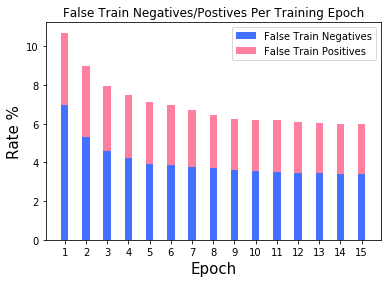

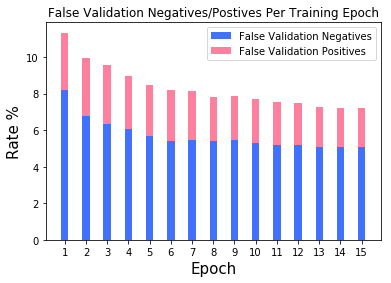

D:\Work\Anaconda\lib\site-packages\ipykernel_launcher.py:99: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


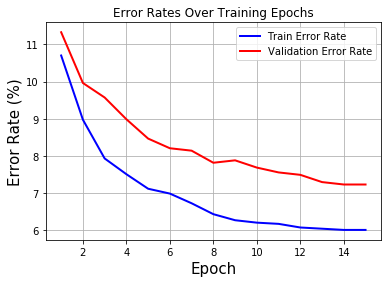

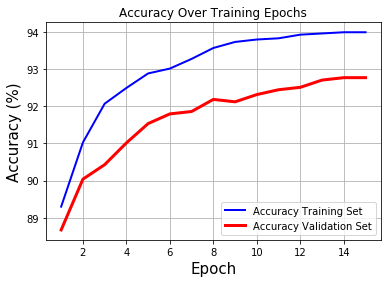

NUMBER OF TRAINING EPOCHS: 15
OVERALL TIME FOR TRAINING: 0.0h:0.0m:3.01017s
LAST TWO VALIDATION COSTS: 7.22656 7.22656
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.001) <<<<<
TRAIN ACCURACY: 94.00% | TEST ACCURACY: 92.77%
TRAIN ERROR RATE: 6.00% | TEST ERROR RATE: 7.23%
TRAIN FALSE NEGATIVES ERROR RATE: 3.43% | TEST FALSE NEGATIVES ERROR RATE: 5.08%
TRAIN FALSE POSITIVES ERROR RATE: 2.58% | TEST FALSE POSITIVES ERROR RATE: 2.15%
---------------------------------------------------------------------------------------


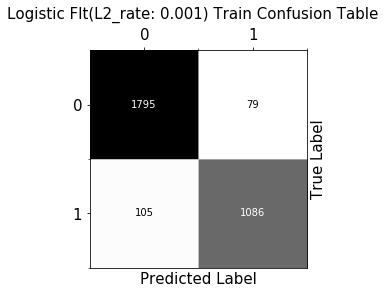

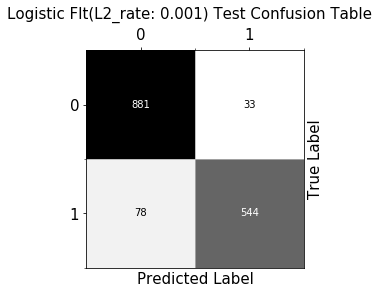

STARTING LOGISTIC FIT(L2_RATE: 0.002)
CONVERGENCE ACHIEVED!


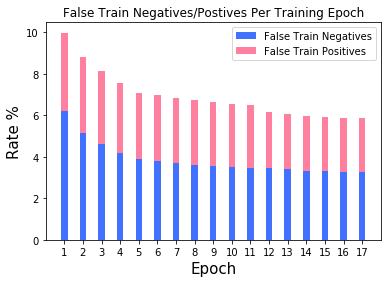

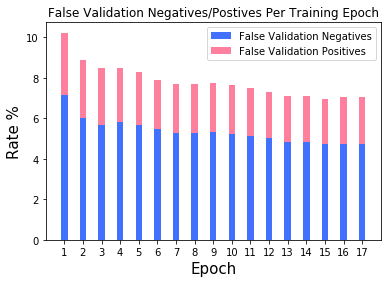

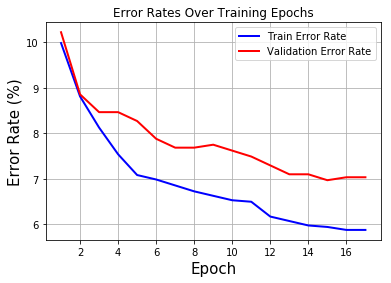

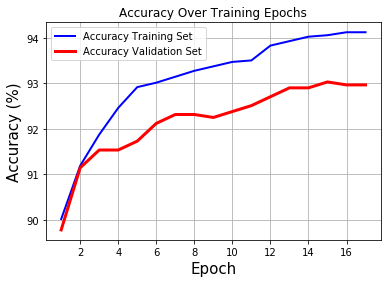

NUMBER OF TRAINING EPOCHS: 17
OVERALL TIME FOR TRAINING: 0.0h:0.0m:3.69521s
LAST TWO VALIDATION COSTS: 7.03125 7.03125
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.002) <<<<<
TRAIN ACCURACY: 94.13% | TEST ACCURACY: 92.97%
TRAIN ERROR RATE: 5.87% | TEST ERROR RATE: 7.03%
TRAIN FALSE NEGATIVES ERROR RATE: 3.26% | TEST FALSE NEGATIVES ERROR RATE: 4.75%
TRAIN FALSE POSITIVES ERROR RATE: 2.61% | TEST FALSE POSITIVES ERROR RATE: 2.28%
---------------------------------------------------------------------------------------


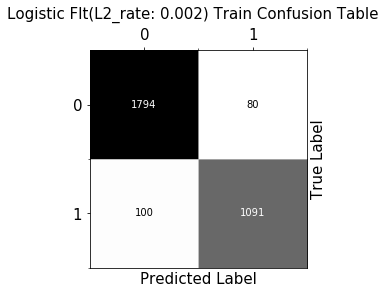

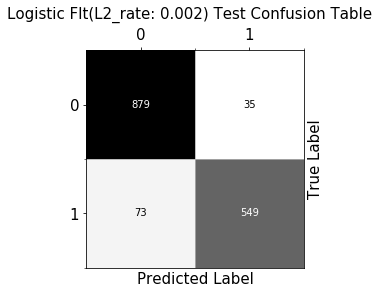

STARTING LOGISTIC FIT(L2_RATE: 0.003)
CONVERGENCE ACHIEVED!


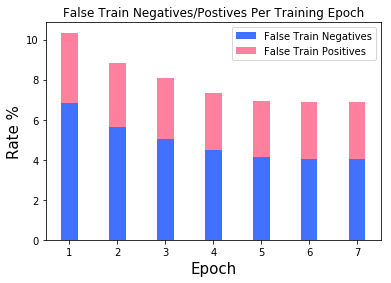

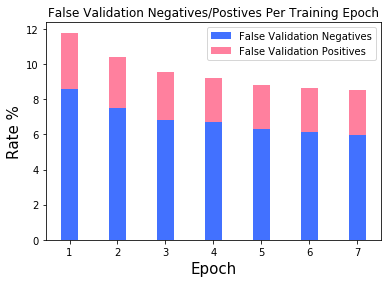

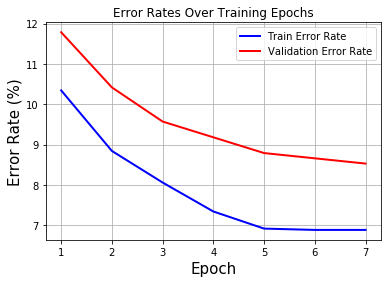

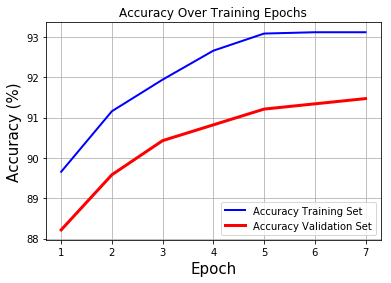

NUMBER OF TRAINING EPOCHS: 7
OVERALL TIME FOR TRAINING: 0.0h:0.0m:1.46608s
LAST TWO VALIDATION COSTS: 8.65885 8.52865
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.003) <<<<<
TRAIN ACCURACY: 93.12% | TEST ACCURACY: 91.47%
TRAIN ERROR RATE: 6.88% | TEST ERROR RATE: 8.53%
TRAIN FALSE NEGATIVES ERROR RATE: 4.05% | TEST FALSE NEGATIVES ERROR RATE: 5.99%
TRAIN FALSE POSITIVES ERROR RATE: 2.84% | TEST FALSE POSITIVES ERROR RATE: 2.54%
---------------------------------------------------------------------------------------


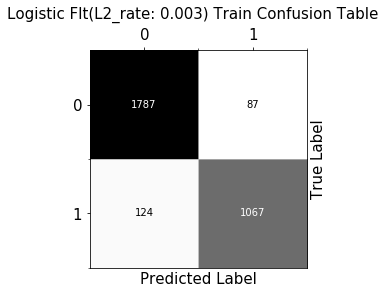

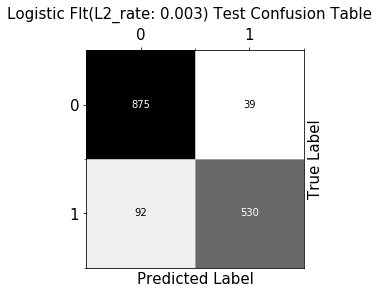

STARTING LOGISTIC FIT(L2_RATE: 0.004)
CONVERGENCE ACHIEVED!


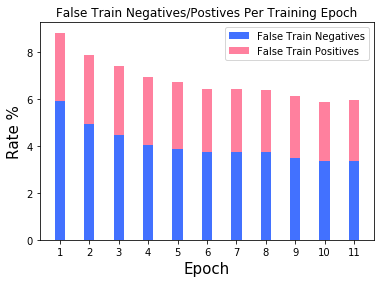

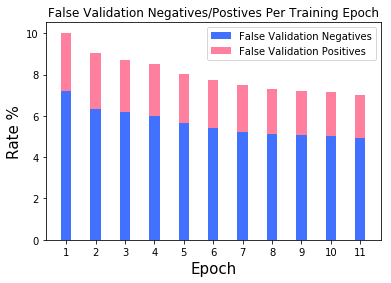

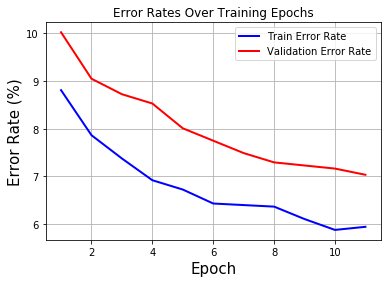

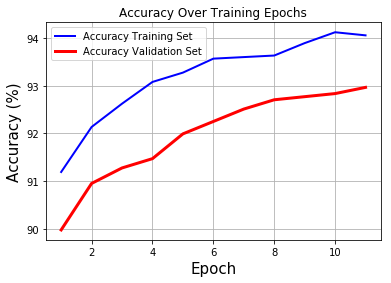

NUMBER OF TRAINING EPOCHS: 11
OVERALL TIME FOR TRAINING: 0.0h:0.0m:2.20913s
LAST TWO VALIDATION COSTS: 7.16146 7.03125
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.004) <<<<<
TRAIN ACCURACY: 94.06% | TEST ACCURACY: 92.97%
TRAIN ERROR RATE: 5.94% | TEST ERROR RATE: 7.03%
TRAIN FALSE NEGATIVES ERROR RATE: 3.36% | TEST FALSE NEGATIVES ERROR RATE: 4.95%
TRAIN FALSE POSITIVES ERROR RATE: 2.58% | TEST FALSE POSITIVES ERROR RATE: 2.08%
---------------------------------------------------------------------------------------


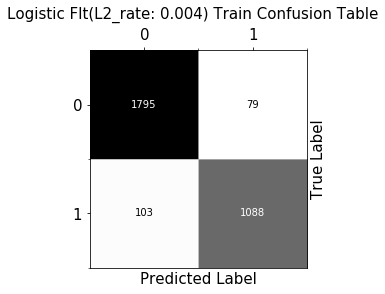

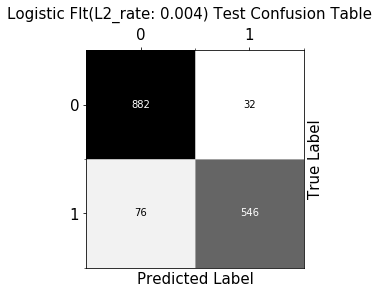

STARTING LOGISTIC FIT(L2_RATE: 0.005)
CONVERGENCE ACHIEVED!


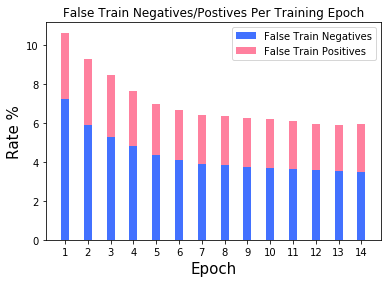

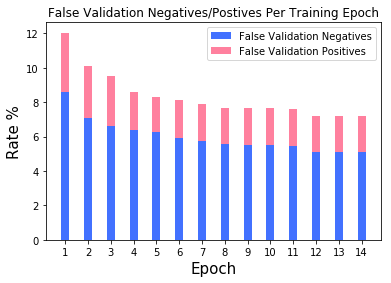

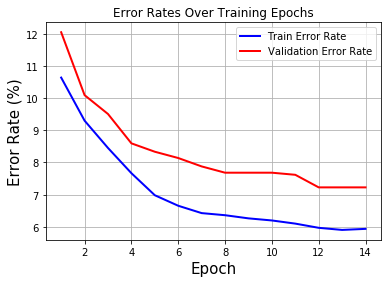

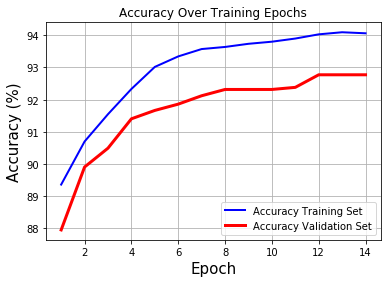

NUMBER OF TRAINING EPOCHS: 14
OVERALL TIME FOR TRAINING: 0.0h:0.0m:2.77816s
LAST TWO VALIDATION COSTS: 7.22656 7.22656
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.005) <<<<<
TRAIN ACCURACY: 94.06% | TEST ACCURACY: 92.77%
TRAIN ERROR RATE: 5.94% | TEST ERROR RATE: 7.23%
TRAIN FALSE NEGATIVES ERROR RATE: 3.49% | TEST FALSE NEGATIVES ERROR RATE: 5.08%
TRAIN FALSE POSITIVES ERROR RATE: 2.45% | TEST FALSE POSITIVES ERROR RATE: 2.15%
---------------------------------------------------------------------------------------


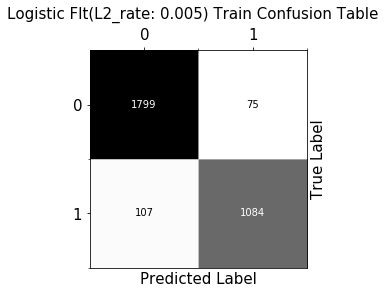

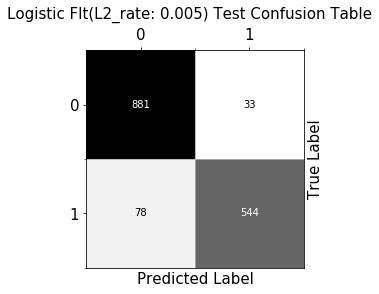

STARTING LOGISTIC FIT(L2_RATE: 0.006)
CONVERGENCE ACHIEVED!


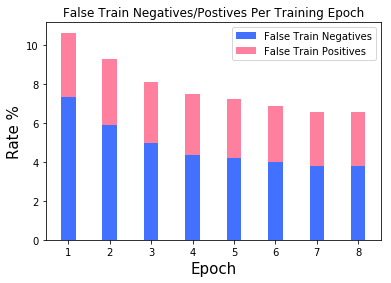

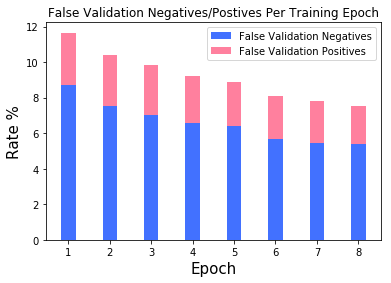

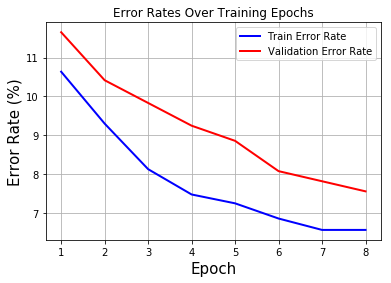

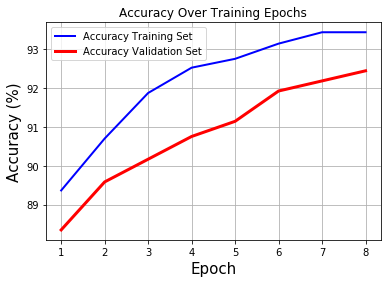

NUMBER OF TRAINING EPOCHS: 8
OVERALL TIME FOR TRAINING: 0.0h:0.0m:1.58309s
LAST TWO VALIDATION COSTS: 7.81250 7.55208
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.006) <<<<<
TRAIN ACCURACY: 93.44% | TEST ACCURACY: 92.45%
TRAIN ERROR RATE: 6.56% | TEST ERROR RATE: 7.55%
TRAIN FALSE NEGATIVES ERROR RATE: 3.78% | TEST FALSE NEGATIVES ERROR RATE: 5.40%
TRAIN FALSE POSITIVES ERROR RATE: 2.77% | TEST FALSE POSITIVES ERROR RATE: 2.15%
---------------------------------------------------------------------------------------


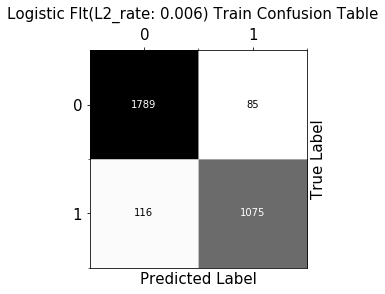

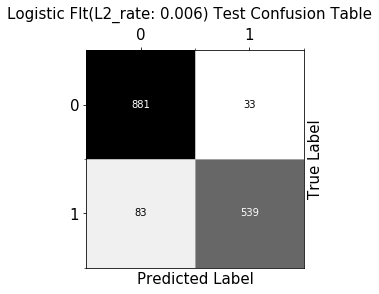

STARTING LOGISTIC FIT(L2_RATE: 0.007)
CONVERGENCE ACHIEVED!


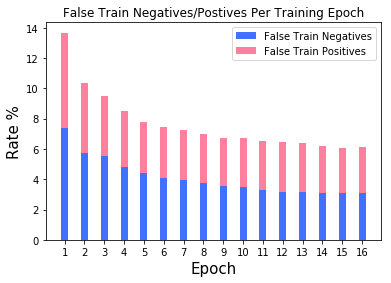

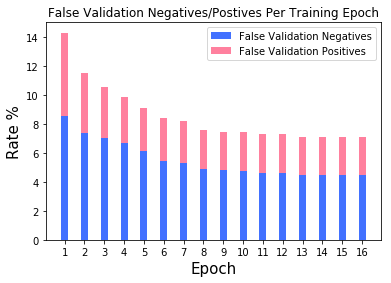

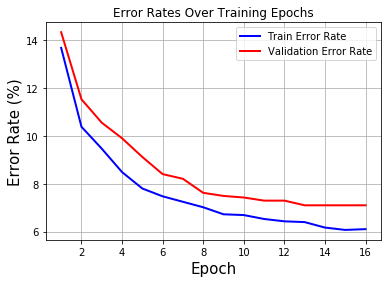

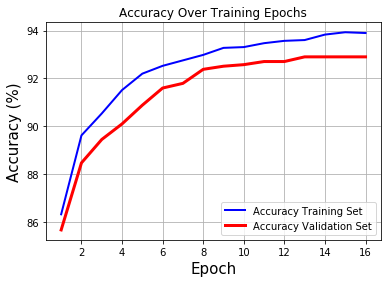

NUMBER OF TRAINING EPOCHS: 16
OVERALL TIME FOR TRAINING: 0.0h:0.0m:3.16518s
LAST TWO VALIDATION COSTS: 7.09635 7.09635
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.007) <<<<<
TRAIN ACCURACY: 93.90% | TEST ACCURACY: 92.90%
TRAIN ERROR RATE: 6.10% | TEST ERROR RATE: 7.10%
TRAIN FALSE NEGATIVES ERROR RATE: 3.07% | TEST FALSE NEGATIVES ERROR RATE: 4.49%
TRAIN FALSE POSITIVES ERROR RATE: 3.03% | TEST FALSE POSITIVES ERROR RATE: 2.60%
---------------------------------------------------------------------------------------


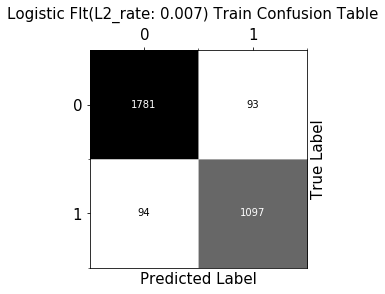

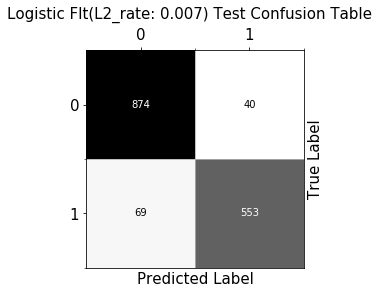

STARTING LOGISTIC FIT(L2_RATE: 0.008)
CONVERGENCE ACHIEVED!


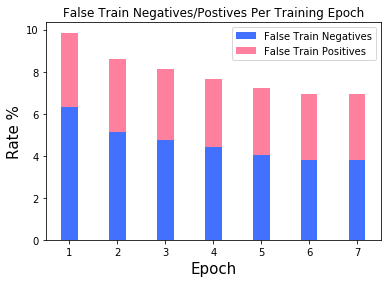

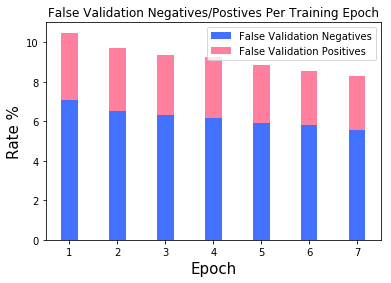

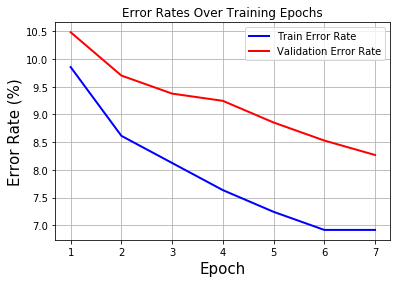

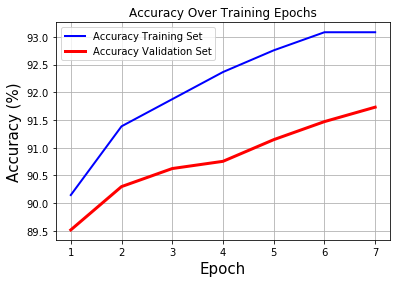

NUMBER OF TRAINING EPOCHS: 7
OVERALL TIME FOR TRAINING: 0.0h:0.0m:1.44108s
LAST TWO VALIDATION COSTS: 8.52865 8.26823
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.008) <<<<<
TRAIN ACCURACY: 93.08% | TEST ACCURACY: 91.73%
TRAIN ERROR RATE: 6.92% | TEST ERROR RATE: 8.27%
TRAIN FALSE NEGATIVES ERROR RATE: 3.82% | TEST FALSE NEGATIVES ERROR RATE: 5.53%
TRAIN FALSE POSITIVES ERROR RATE: 3.10% | TEST FALSE POSITIVES ERROR RATE: 2.73%
---------------------------------------------------------------------------------------


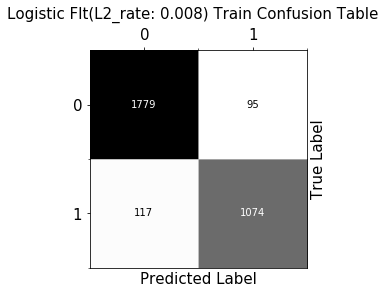

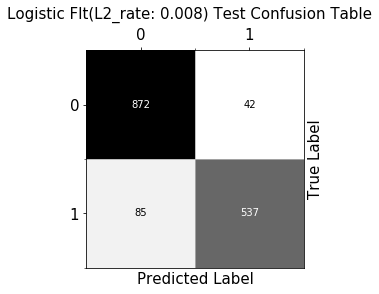

STARTING LOGISTIC FIT(L2_RATE: 0.009)
CONVERGENCE ACHIEVED!


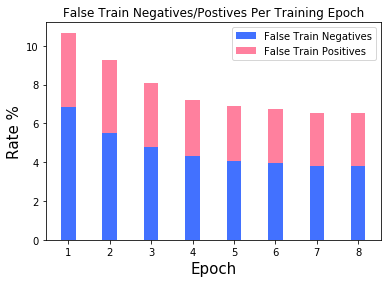

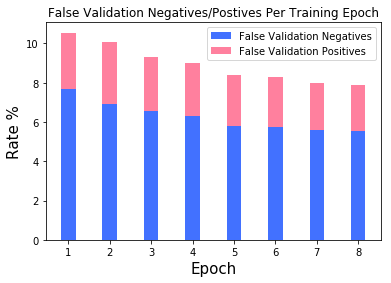

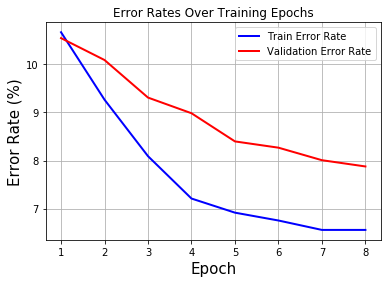

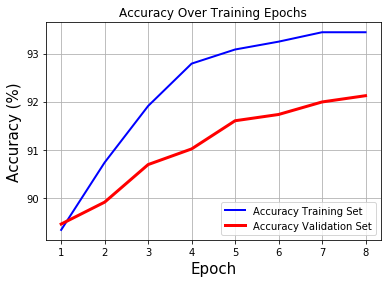

NUMBER OF TRAINING EPOCHS: 8
OVERALL TIME FOR TRAINING: 0.0h:0.0m:1.57309s
LAST TWO VALIDATION COSTS: 8.00781 7.87760
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.009) <<<<<
TRAIN ACCURACY: 93.44% | TEST ACCURACY: 92.12%
TRAIN ERROR RATE: 6.56% | TEST ERROR RATE: 7.88%
TRAIN FALSE NEGATIVES ERROR RATE: 3.78% | TEST FALSE NEGATIVES ERROR RATE: 5.53%
TRAIN FALSE POSITIVES ERROR RATE: 2.77% | TEST FALSE POSITIVES ERROR RATE: 2.34%
---------------------------------------------------------------------------------------


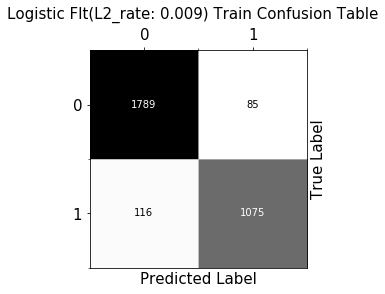

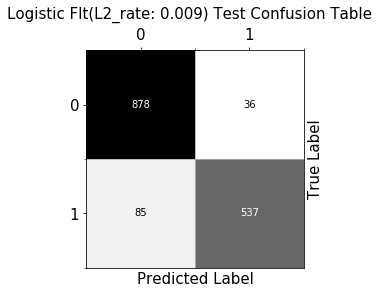

STARTING LOGISTIC FIT(L2_RATE: 0.01)
CONVERGENCE ACHIEVED!


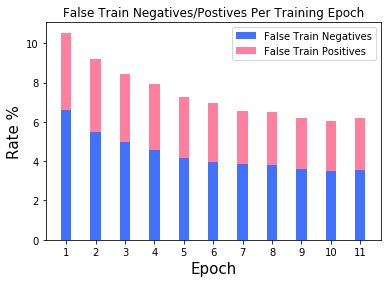

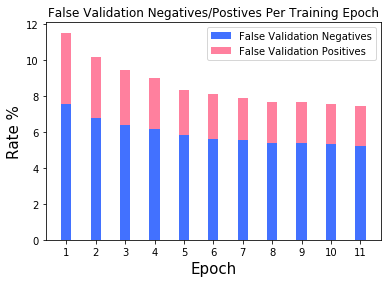

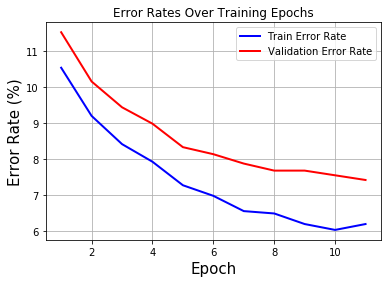

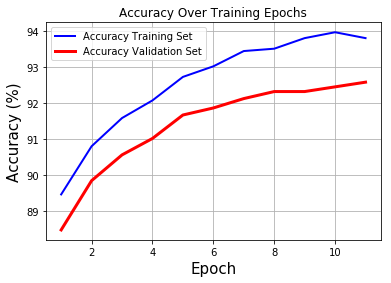

NUMBER OF TRAINING EPOCHS: 11
OVERALL TIME FOR TRAINING: 0.0h:0.0m:2.09012s
LAST TWO VALIDATION COSTS: 7.55208 7.42188
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.01) <<<<<
TRAIN ACCURACY: 93.80% | TEST ACCURACY: 92.58%
TRAIN ERROR RATE: 6.20% | TEST ERROR RATE: 7.42%
TRAIN FALSE NEGATIVES ERROR RATE: 3.56% | TEST FALSE NEGATIVES ERROR RATE: 5.21%
TRAIN FALSE POSITIVES ERROR RATE: 2.64% | TEST FALSE POSITIVES ERROR RATE: 2.21%
---------------------------------------------------------------------------------------


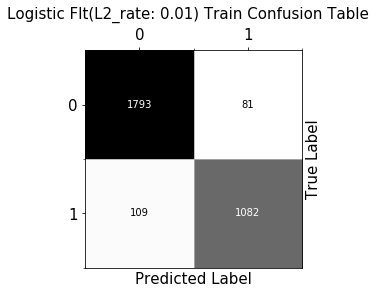

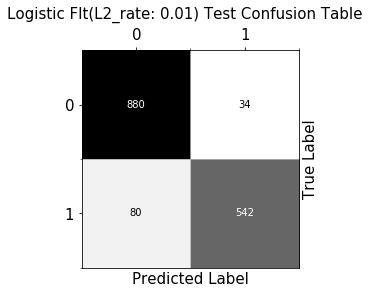

STARTING LOGISTIC FIT(L2_RATE: 0.015)
CONVERGENCE ACHIEVED!


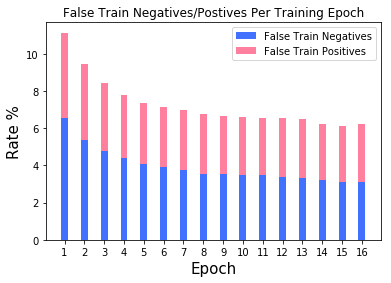

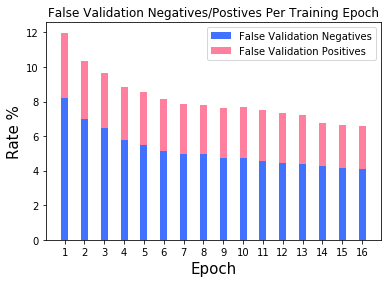

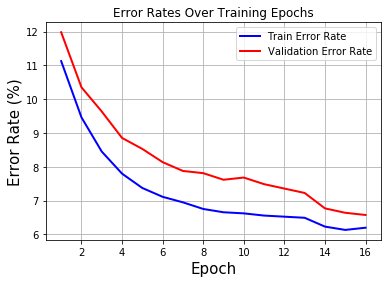

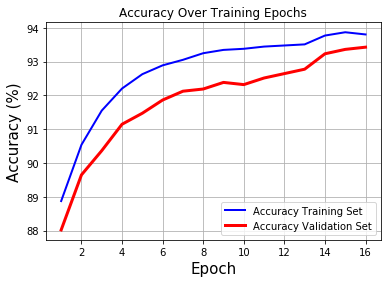

NUMBER OF TRAINING EPOCHS: 16
OVERALL TIME FOR TRAINING: 0.0h:0.0m:3.13718s
LAST TWO VALIDATION COSTS: 6.64062 6.57552
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.015) <<<<<
TRAIN ACCURACY: 93.80% | TEST ACCURACY: 93.42%
TRAIN ERROR RATE: 6.20% | TEST ERROR RATE: 6.58%
TRAIN FALSE NEGATIVES ERROR RATE: 3.10% | TEST FALSE NEGATIVES ERROR RATE: 4.10%
TRAIN FALSE POSITIVES ERROR RATE: 3.10% | TEST FALSE POSITIVES ERROR RATE: 2.47%
---------------------------------------------------------------------------------------


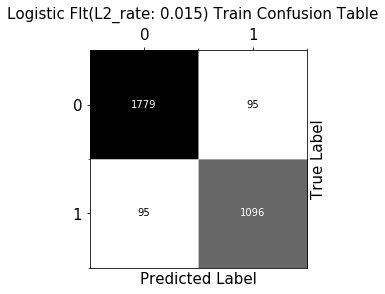

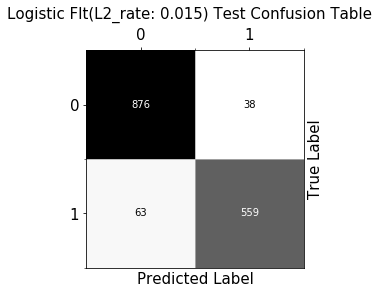

STARTING LOGISTIC FIT(L2_RATE: 0.02)
CONVERGENCE ACHIEVED!


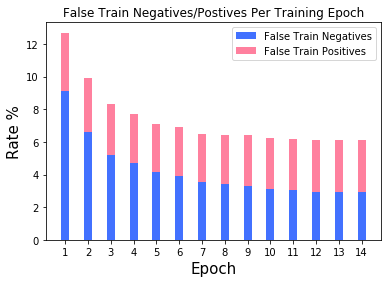

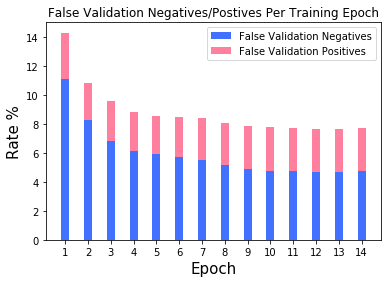

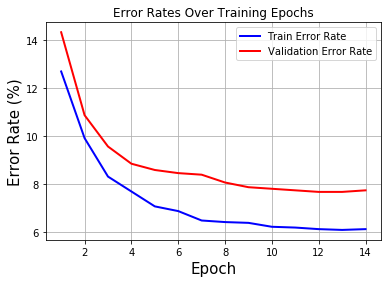

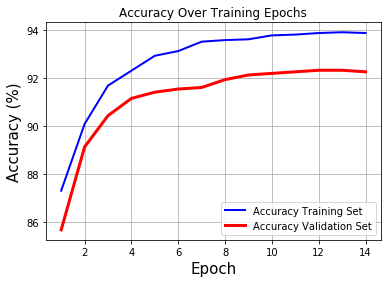

NUMBER OF TRAINING EPOCHS: 14
OVERALL TIME FOR TRAINING: 0.0h:0.0m:4.04323s
LAST TWO VALIDATION COSTS: 7.68229 7.74740
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.02) <<<<<
TRAIN ACCURACY: 93.87% | TEST ACCURACY: 92.25%
TRAIN ERROR RATE: 6.13% | TEST ERROR RATE: 7.75%
TRAIN FALSE NEGATIVES ERROR RATE: 2.90% | TEST FALSE NEGATIVES ERROR RATE: 4.75%
TRAIN FALSE POSITIVES ERROR RATE: 3.23% | TEST FALSE POSITIVES ERROR RATE: 2.99%
---------------------------------------------------------------------------------------


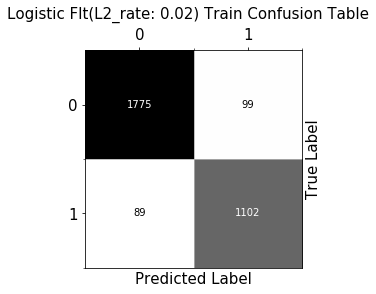

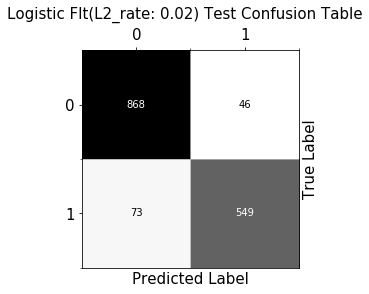

STARTING LOGISTIC FIT(L2_RATE: 0.025)
CONVERGENCE ACHIEVED!


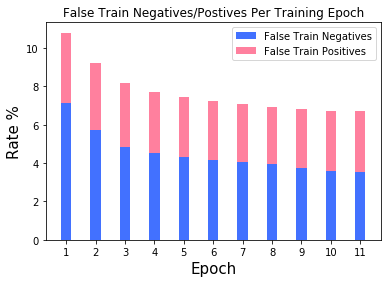

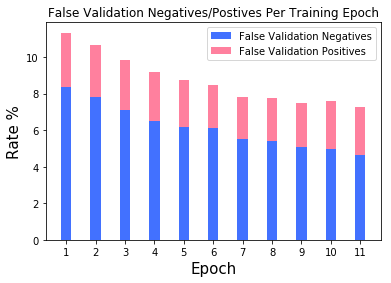

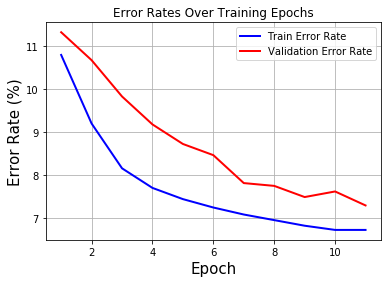

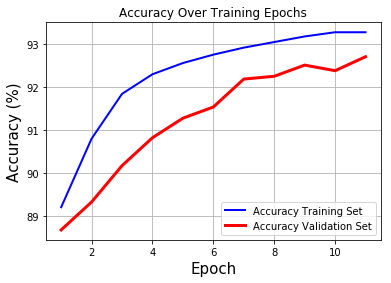

NUMBER OF TRAINING EPOCHS: 11
OVERALL TIME FOR TRAINING: 0.0h:0.0m:3.19018s
LAST TWO VALIDATION COSTS: 7.61719 7.29167
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.025) <<<<<
TRAIN ACCURACY: 93.28% | TEST ACCURACY: 92.71%
TRAIN ERROR RATE: 6.72% | TEST ERROR RATE: 7.29%
TRAIN FALSE NEGATIVES ERROR RATE: 3.52% | TEST FALSE NEGATIVES ERROR RATE: 4.62%
TRAIN FALSE POSITIVES ERROR RATE: 3.20% | TEST FALSE POSITIVES ERROR RATE: 2.67%
---------------------------------------------------------------------------------------


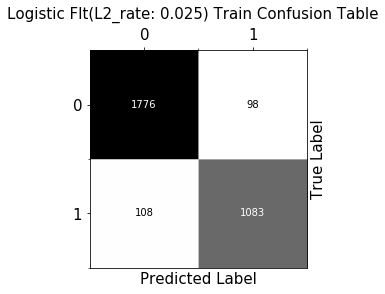

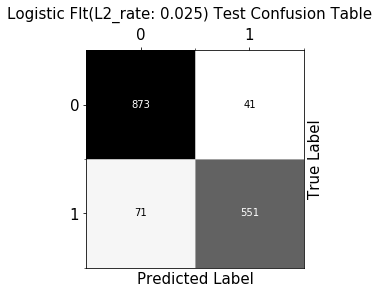

STARTING LOGISTIC FIT(L2_RATE: 0.03)
CONVERGENCE ACHIEVED!


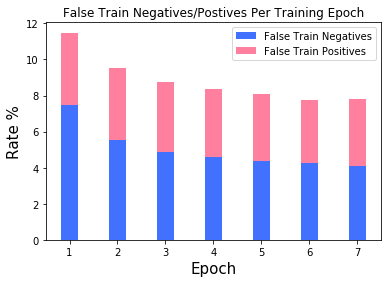

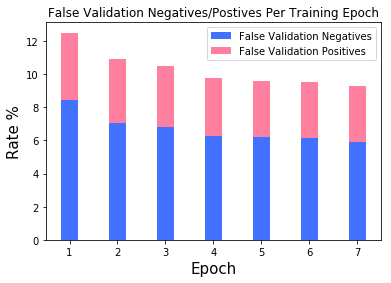

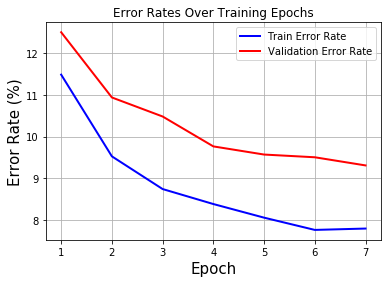

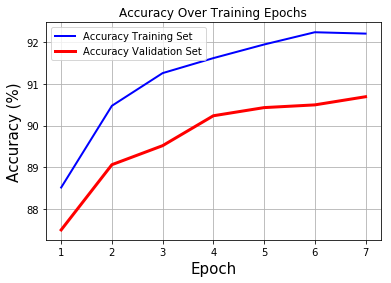

NUMBER OF TRAINING EPOCHS: 7
OVERALL TIME FOR TRAINING: 0.0h:0.0m:1.47908s
LAST TWO VALIDATION COSTS: 9.50521 9.30990
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.03) <<<<<
TRAIN ACCURACY: 92.20% | TEST ACCURACY: 90.69%
TRAIN ERROR RATE: 7.80% | TEST ERROR RATE: 9.31%
TRAIN FALSE NEGATIVES ERROR RATE: 4.11% | TEST FALSE NEGATIVES ERROR RATE: 5.92%
TRAIN FALSE POSITIVES ERROR RATE: 3.69% | TEST FALSE POSITIVES ERROR RATE: 3.39%
---------------------------------------------------------------------------------------


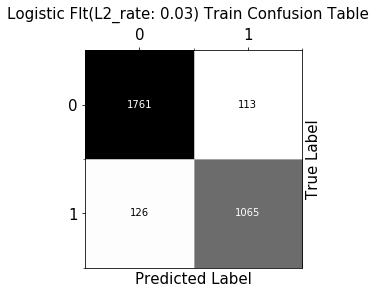

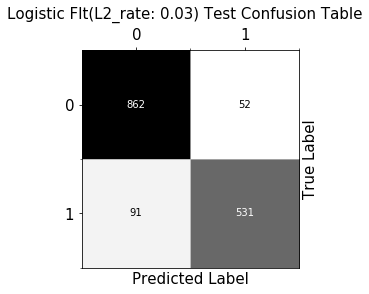

STARTING LOGISTIC FIT(L2_RATE: 0.035)
CONVERGENCE ACHIEVED!


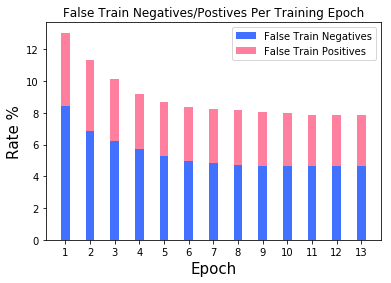

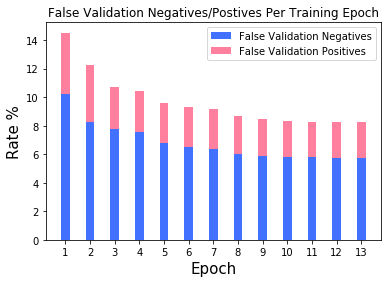

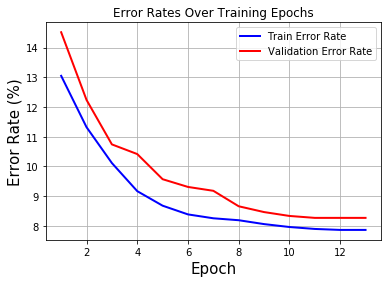

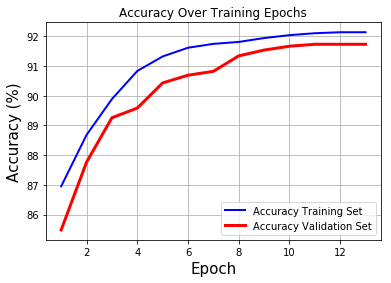

NUMBER OF TRAINING EPOCHS: 13
OVERALL TIME FOR TRAINING: 0.0h:0.0m:2.77616s
LAST TWO VALIDATION COSTS: 8.26823 8.26823
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.035) <<<<<
TRAIN ACCURACY: 92.14% | TEST ACCURACY: 91.73%
TRAIN ERROR RATE: 7.86% | TEST ERROR RATE: 8.27%
TRAIN FALSE NEGATIVES ERROR RATE: 4.63% | TEST FALSE NEGATIVES ERROR RATE: 5.73%
TRAIN FALSE POSITIVES ERROR RATE: 3.23% | TEST FALSE POSITIVES ERROR RATE: 2.54%
---------------------------------------------------------------------------------------


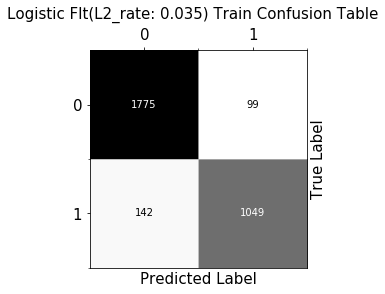

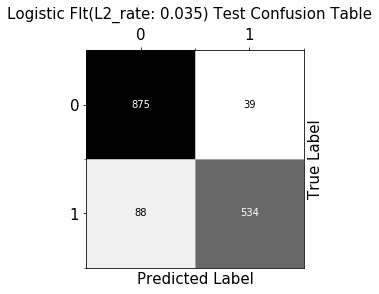

STARTING LOGISTIC FIT(L2_RATE: 0.04)
CONVERGENCE ACHIEVED!


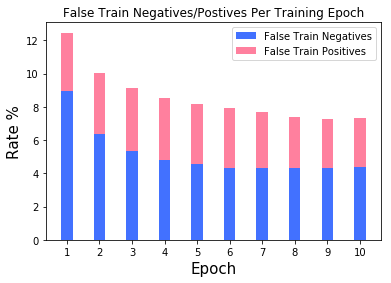

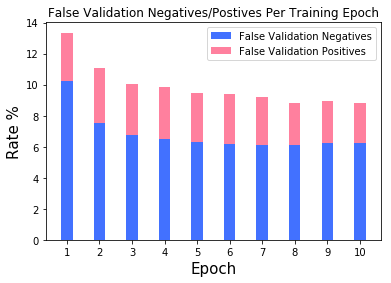

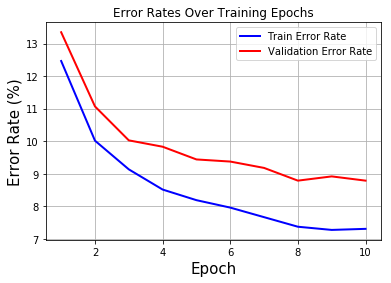

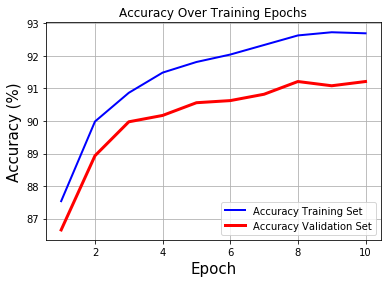

NUMBER OF TRAINING EPOCHS: 10
OVERALL TIME FOR TRAINING: 0.0h:0.0m:1.99911s
LAST TWO VALIDATION COSTS: 8.91927 8.78906
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.04) <<<<<
TRAIN ACCURACY: 92.69% | TEST ACCURACY: 91.21%
TRAIN ERROR RATE: 7.31% | TEST ERROR RATE: 8.79%
TRAIN FALSE NEGATIVES ERROR RATE: 4.40% | TEST FALSE NEGATIVES ERROR RATE: 6.25%
TRAIN FALSE POSITIVES ERROR RATE: 2.90% | TEST FALSE POSITIVES ERROR RATE: 2.54%
---------------------------------------------------------------------------------------


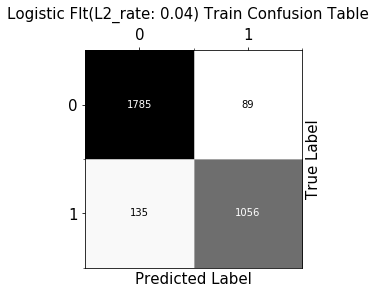

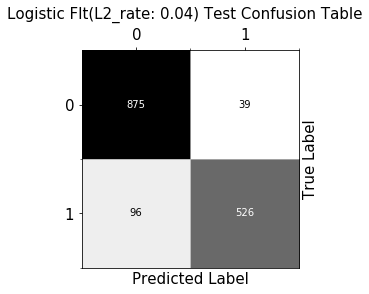

STARTING LOGISTIC FIT(L2_RATE: 0.045)
CONVERGENCE ACHIEVED!


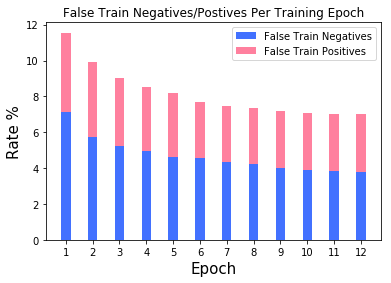

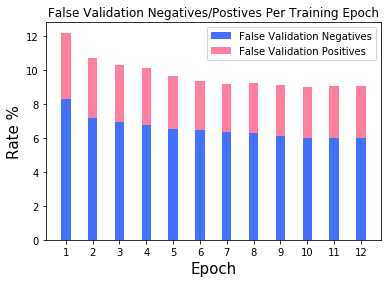

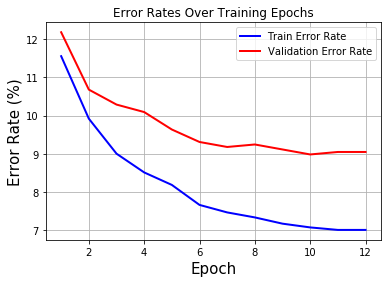

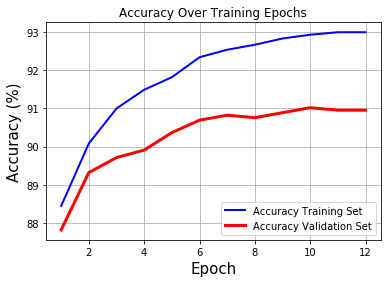

NUMBER OF TRAINING EPOCHS: 12
OVERALL TIME FOR TRAINING: 0.0h:0.0m:2.42214s
LAST TWO VALIDATION COSTS: 9.04948 9.04948
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.045) <<<<<
TRAIN ACCURACY: 92.99% | TEST ACCURACY: 90.95%
TRAIN ERROR RATE: 7.01% | TEST ERROR RATE: 9.05%
TRAIN FALSE NEGATIVES ERROR RATE: 3.78% | TEST FALSE NEGATIVES ERROR RATE: 5.99%
TRAIN FALSE POSITIVES ERROR RATE: 3.23% | TEST FALSE POSITIVES ERROR RATE: 3.06%
---------------------------------------------------------------------------------------


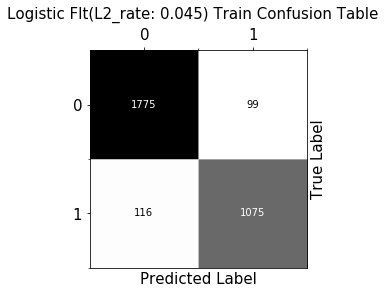

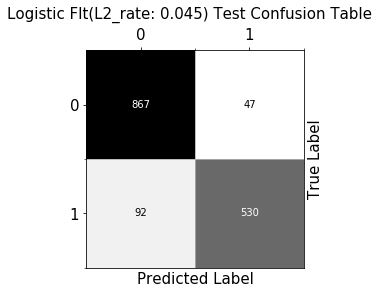

STARTING LOGISTIC FIT(L2_RATE: 0.05)
CONVERGENCE ACHIEVED!


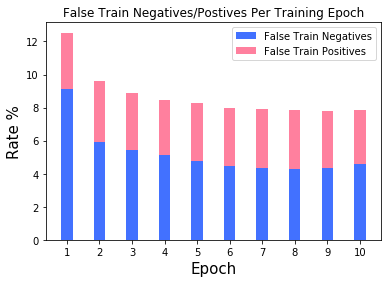

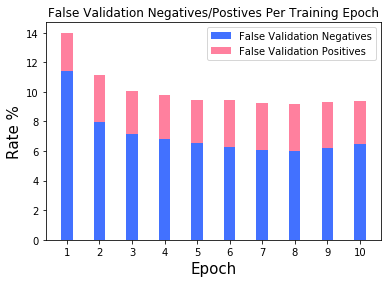

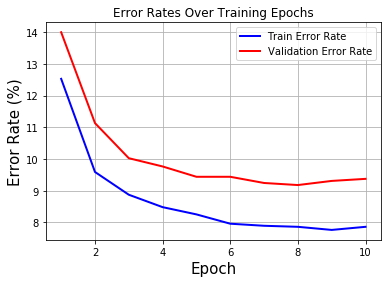

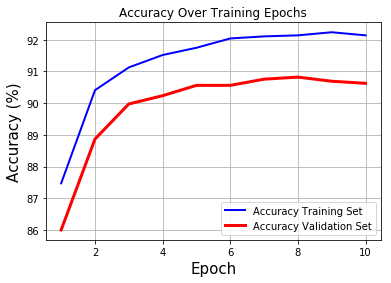

NUMBER OF TRAINING EPOCHS: 10
OVERALL TIME FOR TRAINING: 0.0h:0.0m:1.98911s
LAST TWO VALIDATION COSTS: 9.30990 9.37500
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.05) <<<<<
TRAIN ACCURACY: 92.14% | TEST ACCURACY: 90.62%
TRAIN ERROR RATE: 7.86% | TEST ERROR RATE: 9.38%
TRAIN FALSE NEGATIVES ERROR RATE: 4.57% | TEST FALSE NEGATIVES ERROR RATE: 6.45%
TRAIN FALSE POSITIVES ERROR RATE: 3.30% | TEST FALSE POSITIVES ERROR RATE: 2.93%
---------------------------------------------------------------------------------------


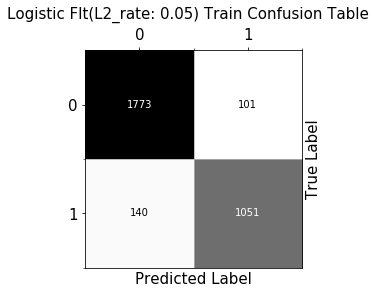

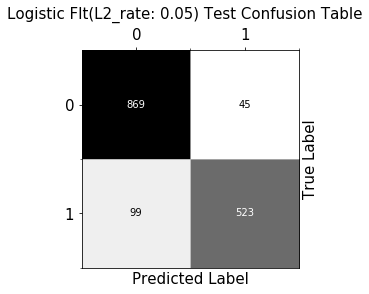

STARTING LOGISTIC FIT(L2_RATE: 0.055)
CONVERGENCE ACHIEVED!


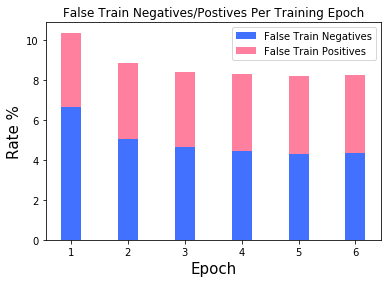

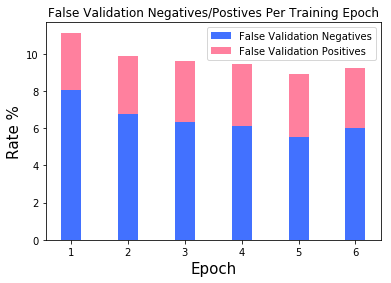

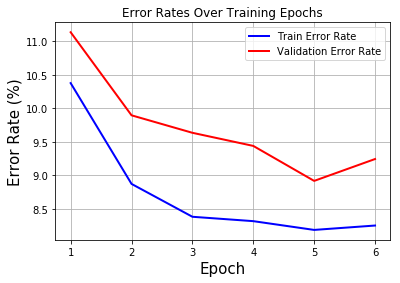

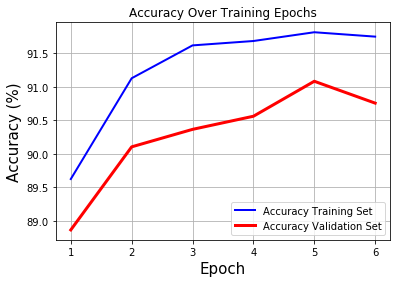

NUMBER OF TRAINING EPOCHS: 6
OVERALL TIME FOR TRAINING: 0.0h:0.0m:1.17207s
LAST TWO VALIDATION COSTS: 8.91927 9.24479
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.055) <<<<<
TRAIN ACCURACY: 91.75% | TEST ACCURACY: 90.76%
TRAIN ERROR RATE: 8.25% | TEST ERROR RATE: 9.24%
TRAIN FALSE NEGATIVES ERROR RATE: 4.34% | TEST FALSE NEGATIVES ERROR RATE: 5.99%
TRAIN FALSE POSITIVES ERROR RATE: 3.92% | TEST FALSE POSITIVES ERROR RATE: 3.26%
---------------------------------------------------------------------------------------


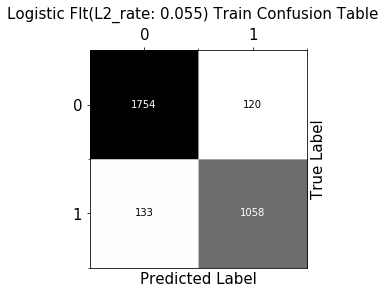

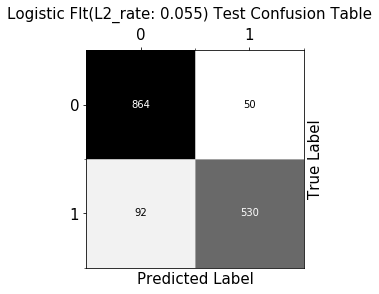

STARTING LOGISTIC FIT(L2_RATE: 0.06)
CONVERGENCE ACHIEVED!


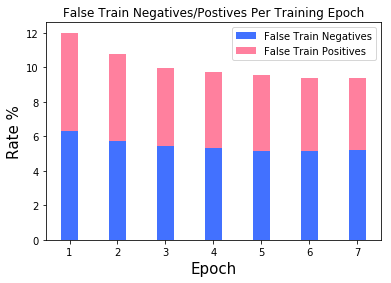

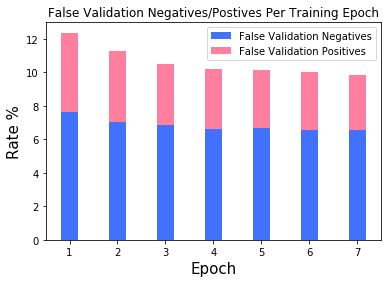

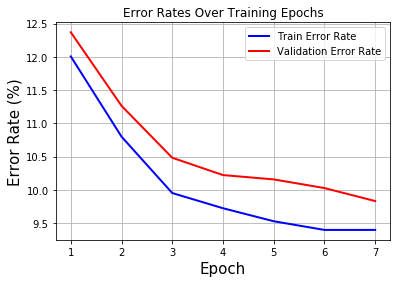

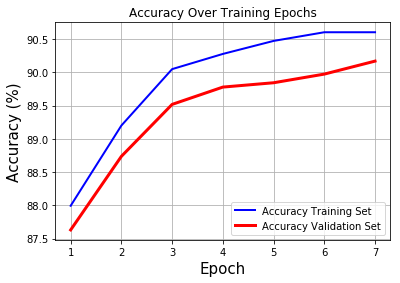

NUMBER OF TRAINING EPOCHS: 7
OVERALL TIME FOR TRAINING: 0.0h:0.0m:1.36708s
LAST TWO VALIDATION COSTS: 10.02604 9.83073
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.06) <<<<<
TRAIN ACCURACY: 90.60% | TEST ACCURACY: 90.17%
TRAIN ERROR RATE: 9.40% | TEST ERROR RATE: 9.83%
TRAIN FALSE NEGATIVES ERROR RATE: 5.22% | TEST FALSE NEGATIVES ERROR RATE: 6.58%
TRAIN FALSE POSITIVES ERROR RATE: 4.18% | TEST FALSE POSITIVES ERROR RATE: 3.26%
---------------------------------------------------------------------------------------


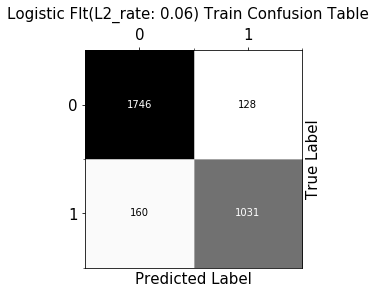

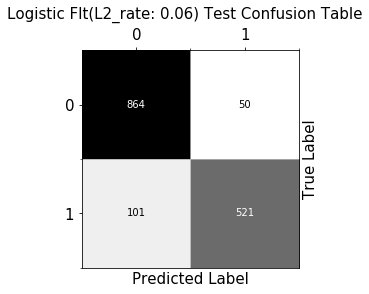

STARTING LOGISTIC FIT(L2_RATE: 0.065)
CONVERGENCE ACHIEVED!


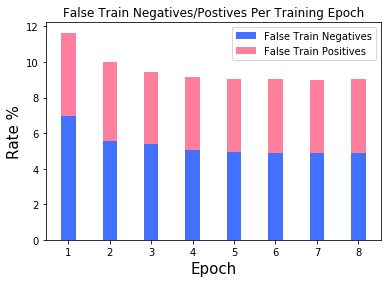

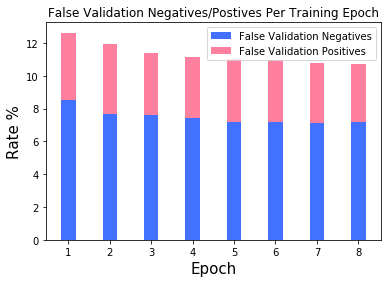

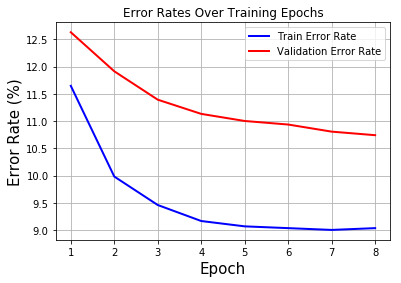

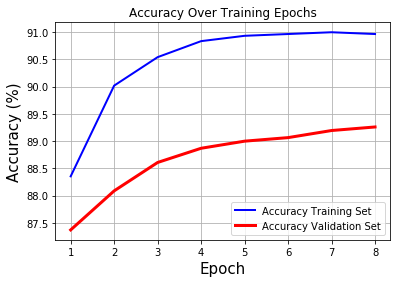

NUMBER OF TRAINING EPOCHS: 8
OVERALL TIME FOR TRAINING: 0.0h:0.0m:1.55309s
LAST TWO VALIDATION COSTS: 10.80729 10.74219
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.065) <<<<<
TRAIN ACCURACY: 90.96% | TEST ACCURACY: 89.26%
TRAIN ERROR RATE: 9.04% | TEST ERROR RATE: 10.74%
TRAIN FALSE NEGATIVES ERROR RATE: 4.89% | TEST FALSE NEGATIVES ERROR RATE: 7.16%
TRAIN FALSE POSITIVES ERROR RATE: 4.14% | TEST FALSE POSITIVES ERROR RATE: 3.58%
---------------------------------------------------------------------------------------


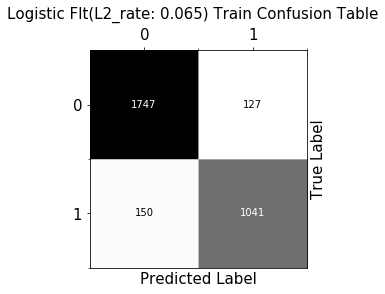

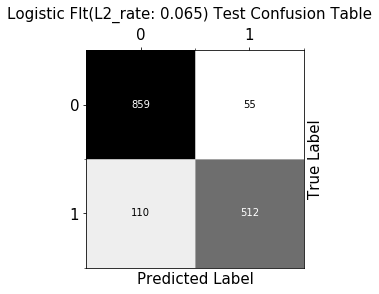

STARTING LOGISTIC FIT(L2_RATE: 0.07)
CONVERGENCE ACHIEVED!


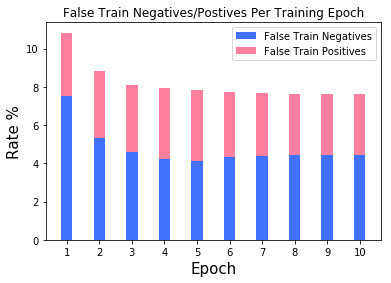

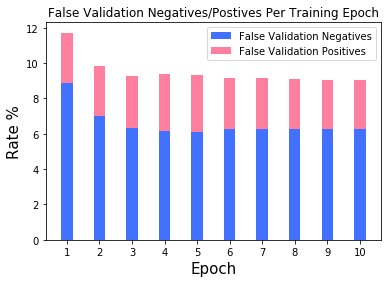

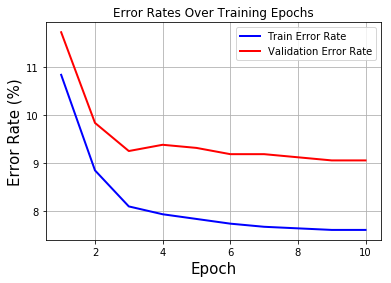

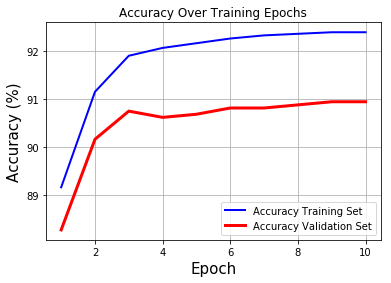

NUMBER OF TRAINING EPOCHS: 10
OVERALL TIME FOR TRAINING: 0.0h:0.0m:2.02012s
LAST TWO VALIDATION COSTS: 9.04948 9.04948
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.07) <<<<<
TRAIN ACCURACY: 92.40% | TEST ACCURACY: 90.95%
TRAIN ERROR RATE: 7.60% | TEST ERROR RATE: 9.05%
TRAIN FALSE NEGATIVES ERROR RATE: 4.44% | TEST FALSE NEGATIVES ERROR RATE: 6.25%
TRAIN FALSE POSITIVES ERROR RATE: 3.16% | TEST FALSE POSITIVES ERROR RATE: 2.80%
---------------------------------------------------------------------------------------


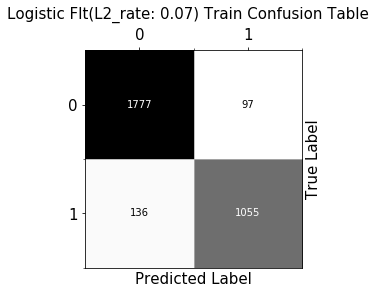

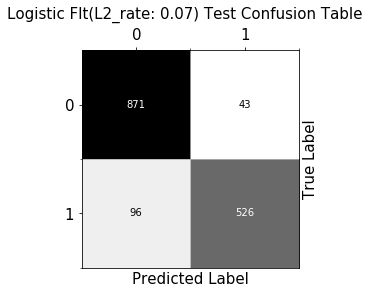

STARTING LOGISTIC FIT(L2_RATE: 0.075)
CONVERGENCE ACHIEVED!


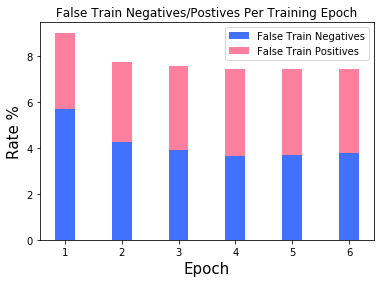

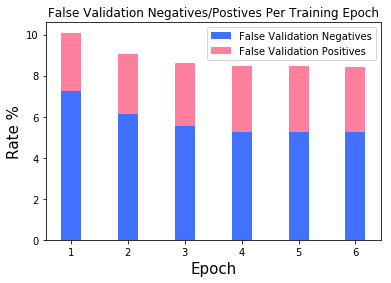

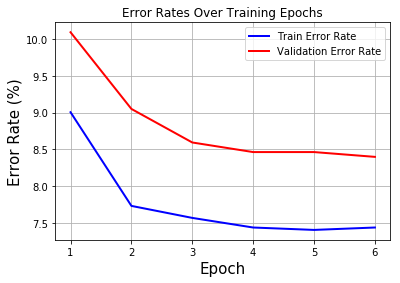

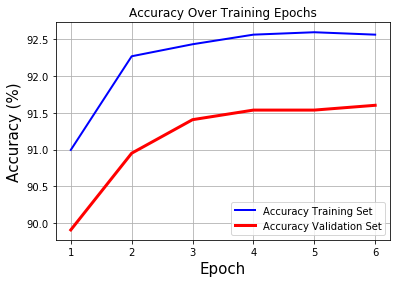

NUMBER OF TRAINING EPOCHS: 6
OVERALL TIME FOR TRAINING: 0.0h:0.0m:1.19107s
LAST TWO VALIDATION COSTS: 8.46354 8.39844
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.075) <<<<<
TRAIN ACCURACY: 92.56% | TEST ACCURACY: 91.60%
TRAIN ERROR RATE: 7.44% | TEST ERROR RATE: 8.40%
TRAIN FALSE NEGATIVES ERROR RATE: 3.78% | TEST FALSE NEGATIVES ERROR RATE: 5.27%
TRAIN FALSE POSITIVES ERROR RATE: 3.65% | TEST FALSE POSITIVES ERROR RATE: 3.12%
---------------------------------------------------------------------------------------


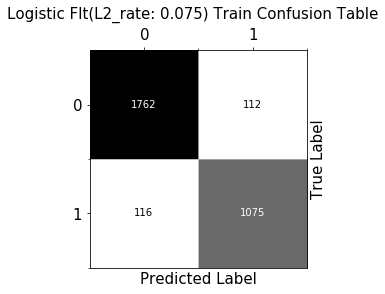

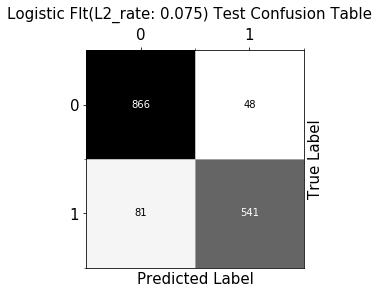

STARTING LOGISTIC FIT(L2_RATE: 0.08)
CONVERGENCE ACHIEVED!


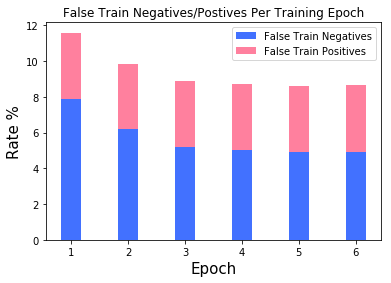

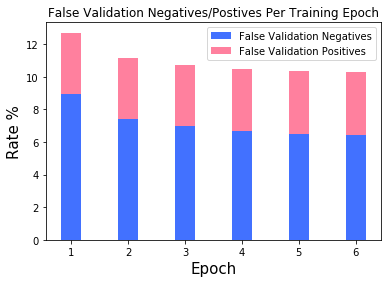

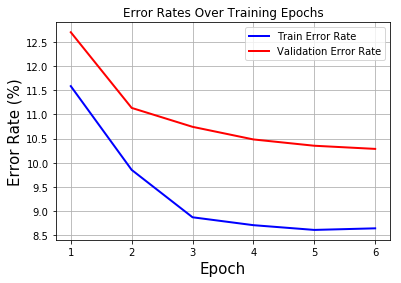

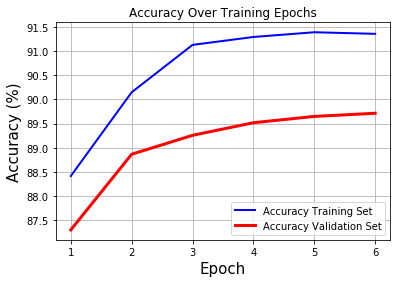

NUMBER OF TRAINING EPOCHS: 6
OVERALL TIME FOR TRAINING: 0.0h:0.0m:1.16807s
LAST TWO VALIDATION COSTS: 10.35156 10.28646
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.08) <<<<<
TRAIN ACCURACY: 91.35% | TEST ACCURACY: 89.71%
TRAIN ERROR RATE: 8.65% | TEST ERROR RATE: 10.29%
TRAIN FALSE NEGATIVES ERROR RATE: 4.93% | TEST FALSE NEGATIVES ERROR RATE: 6.45%
TRAIN FALSE POSITIVES ERROR RATE: 3.72% | TEST FALSE POSITIVES ERROR RATE: 3.84%
---------------------------------------------------------------------------------------


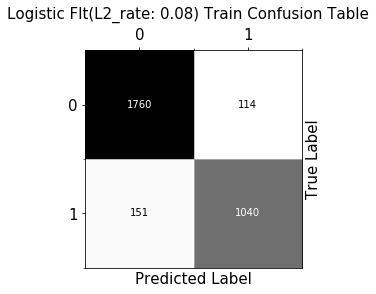

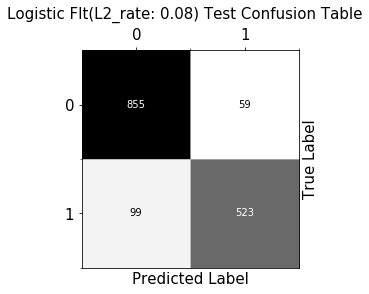

STARTING LOGISTIC FIT(L2_RATE: 0.085)
CONVERGENCE ACHIEVED!


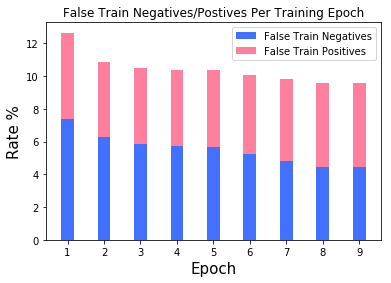

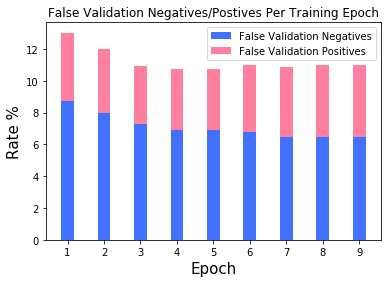

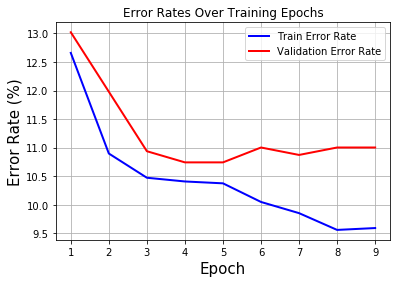

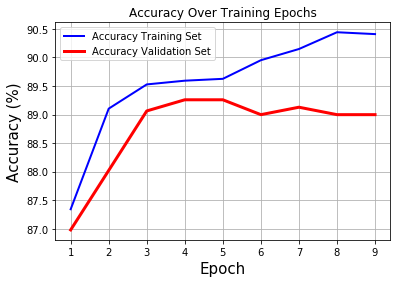

NUMBER OF TRAINING EPOCHS: 9
OVERALL TIME FOR TRAINING: 0.0h:0.0m:1.73110s
LAST TWO VALIDATION COSTS: 11.00260 11.00260
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.085) <<<<<
TRAIN ACCURACY: 90.41% | TEST ACCURACY: 89.00%
TRAIN ERROR RATE: 9.59% | TEST ERROR RATE: 11.00%
TRAIN FALSE NEGATIVES ERROR RATE: 4.44% | TEST FALSE NEGATIVES ERROR RATE: 6.45%
TRAIN FALSE POSITIVES ERROR RATE: 5.15% | TEST FALSE POSITIVES ERROR RATE: 4.56%
---------------------------------------------------------------------------------------


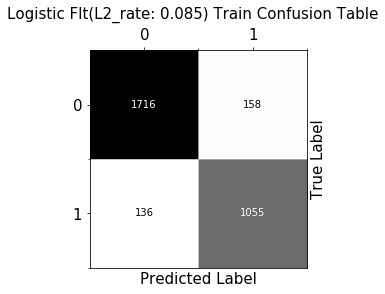

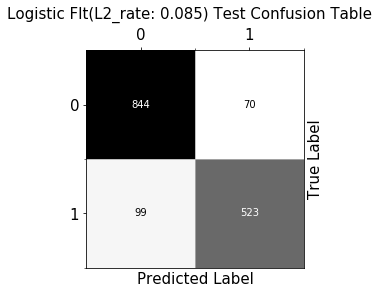

STARTING LOGISTIC FIT(L2_RATE: 0.09)


D:\Work\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


CONVERGENCE ACHIEVED!


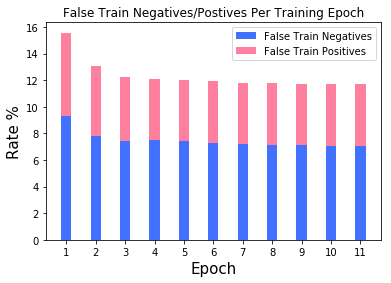

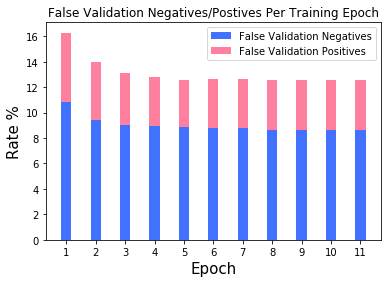

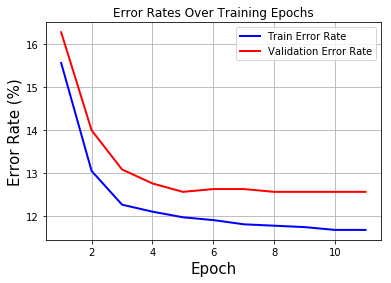

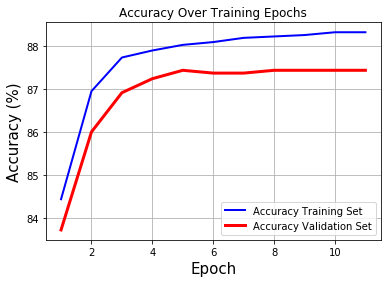

NUMBER OF TRAINING EPOCHS: 11
OVERALL TIME FOR TRAINING: 0.0h:0.0m:2.16612s
LAST TWO VALIDATION COSTS: 12.56510 12.56510
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.09) <<<<<
TRAIN ACCURACY: 88.32% | TEST ACCURACY: 87.43%
TRAIN ERROR RATE: 11.68% | TEST ERROR RATE: 12.57%
TRAIN FALSE NEGATIVES ERROR RATE: 7.05% | TEST FALSE NEGATIVES ERROR RATE: 8.66%
TRAIN FALSE POSITIVES ERROR RATE: 4.63% | TEST FALSE POSITIVES ERROR RATE: 3.91%
---------------------------------------------------------------------------------------


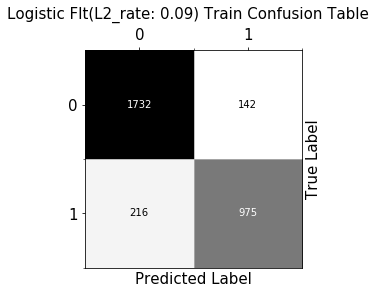

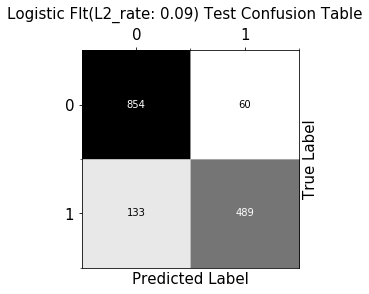

STARTING LOGISTIC FIT(L2_RATE: 0.095)
CONVERGENCE ACHIEVED!


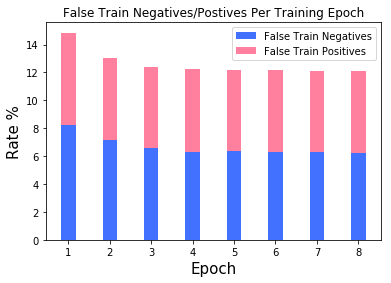

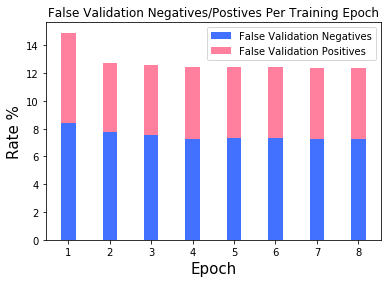

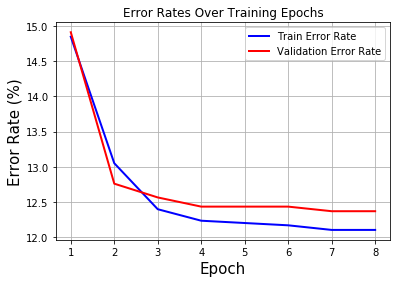

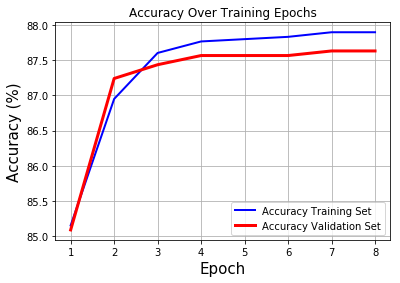

NUMBER OF TRAINING EPOCHS: 8
OVERALL TIME FOR TRAINING: 0.0h:0.0m:1.58309s
LAST TWO VALIDATION COSTS: 12.36979 12.36979
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.095) <<<<<
TRAIN ACCURACY: 87.90% | TEST ACCURACY: 87.63%
TRAIN ERROR RATE: 12.10% | TEST ERROR RATE: 12.37%
TRAIN FALSE NEGATIVES ERROR RATE: 6.23% | TEST FALSE NEGATIVES ERROR RATE: 7.23%
TRAIN FALSE POSITIVES ERROR RATE: 5.87% | TEST FALSE POSITIVES ERROR RATE: 5.14%
---------------------------------------------------------------------------------------


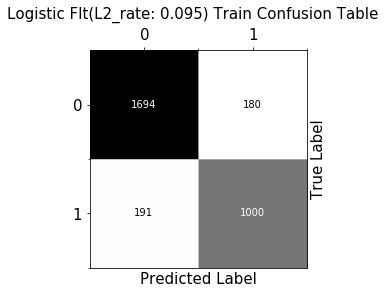

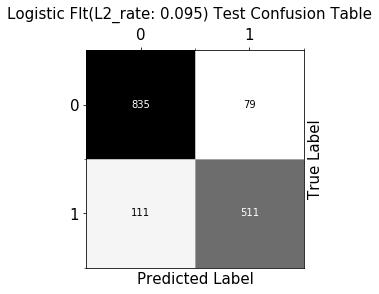

STARTING LOGISTIC FIT(L2_RATE: 0.1)
CONVERGENCE ACHIEVED!


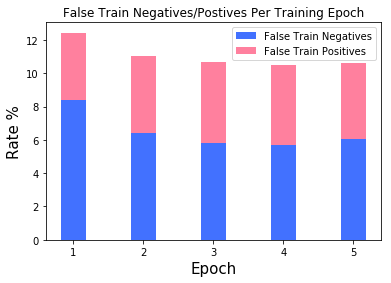

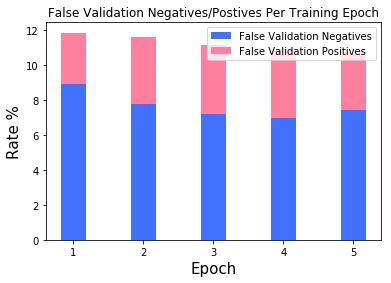

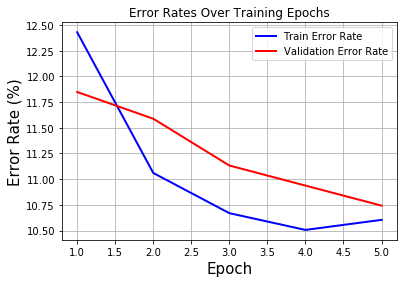

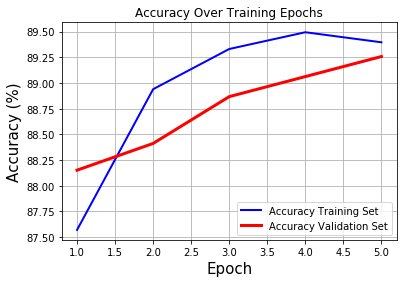

NUMBER OF TRAINING EPOCHS: 5
OVERALL TIME FOR TRAINING: 0.0h:0.0m:0.97906s
LAST TWO VALIDATION COSTS: 10.93750 10.74219
---------------------------------------------------------------------------------------
>>>>> LOGISTIC REGRESSION NEURON(L2_rate = 0.1) <<<<<
TRAIN ACCURACY: 89.40% | TEST ACCURACY: 89.26%
TRAIN ERROR RATE: 10.60% | TEST ERROR RATE: 10.74%
TRAIN FALSE NEGATIVES ERROR RATE: 6.07% | TEST FALSE NEGATIVES ERROR RATE: 7.42%
TRAIN FALSE POSITIVES ERROR RATE: 4.54% | TEST FALSE POSITIVES ERROR RATE: 3.32%
---------------------------------------------------------------------------------------


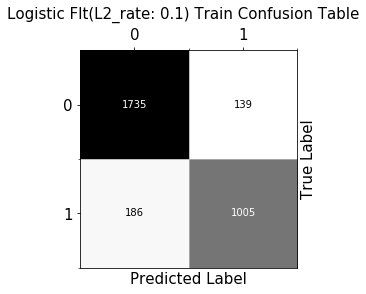

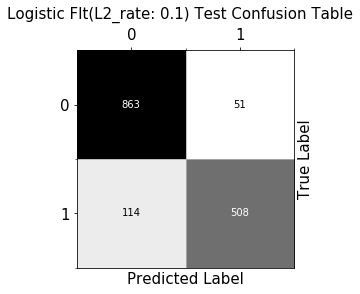

DATA FOR THE FIT


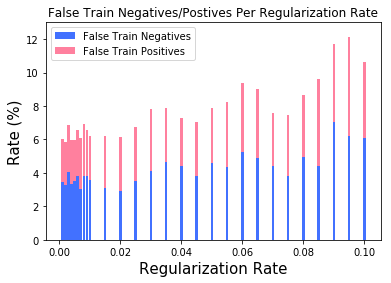

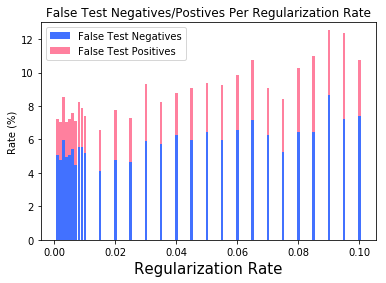

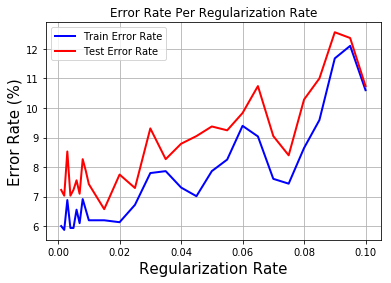

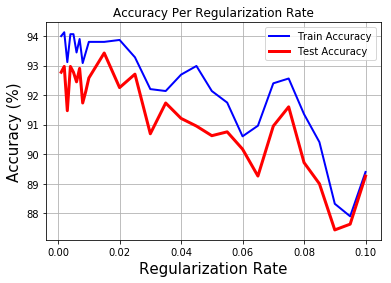

OVERALL TIME FOR FIT: 0.0h:1.0m:30.60618s
BEST PERFORMANCE ACHIEVED FOR: L2_rate = 0.015
TRAIN ACCURACY: 93.80097879282219% | TEST ACCURACY: 93.42447916666666%
TRAIN ERROR RATE: 6.20% | TEST ERROR RATE: 6.58%
TRAIN FALSE NEGATIVES ERROR RATE: 3.10% | TEST FALSE NEGATIVES ERROR RATE: 4.10%
TRAIN FALSE POSITIVES ERROR RATE: 3.10% | TEST FALSE POSITIVES ERROR RATE: 2.47%


In [13]:
# RUN
fit_logistic(L2_rates, X_TRAIN_LOG, T_TRAIN, X_TEST_LOG, T_TEST, X_TEST_LOG, T_TEST)

# Q4 K-Nearest Neighbors

In [44]:
class KNearestNeighbors(object):
    """k-Nearest Neighbors classifier with L2(Euclidean) distance."""
    
    def __init__(self):
        """Declare the classifier fields."""
        self.X_train = None
        self.T_train = None
        
    def train(self, X_train, T_train):
        """Initialize the classifier fields with the training dataset."""
        self.X_train = X_train
        self.T_train = T_train
        
    def euclidean_distance(self, X_pred):
        """Calculate the Euclidean distances between the input samples (X_pred) and the training samples."""
        return np.sqrt(-2*np.dot(X_pred, self.X_train.T) + np.sum(self.X_train**2,axis=1) + np.sum(X_pred**2, axis=1)[:, np.newaxis])
    
    def predict(self, X_pred, k=1):
        """Predicts the labels of the input samples by calculating the Euclidean distances between them
           & the training samples, and picking the most common label in the k-nearest training samples."""
        num_pred = X_pred.shape[0]
        num_train = self.X_train.shape[0]
        #Calculating Euclidean distances
        dists = np.zeros((num_pred, num_train))
        dists = self.euclidean_distance(X_pred)
        Y_pred = np.zeros(num_pred)
        #Picking the indexes of the k-nearest training samples
        KNN_idx = np.argpartition(dists, k, axis=1)[:, :k]
        #Getting the k-nearest training samples' labels
        KNN_lab = self.T_train[KNN_idx.reshape(num_pred*k)].reshape(num_pred,k)
        #Making a prediction by picking the most common label from the k-nearest labels
        Y_pred = np.apply_along_axis(lambda x: np.bincount(x, minlength=10), axis=1, arr=KNN_lab).argmax(axis=1)
        return Y_pred

In [45]:
def cross_validate(KNearestNeighbors, X_train, T_train, K_values):
    """Perform a 5-fold cross-validation using the train dataset to pick the optimal K in between the K_values."""
    accuracy_per_k = []
    #Perform cross-validation across all Ks
    for k in K_values:
        print('Cross-Validation for K=',k)
        k_accuracy = []
        #Fit 5 folds for each K
        for fold in range(5):
            print('Processing Fold',fold+1)
            #Create the sub-fold train dataset, consisting of 4 folds of input samples
            fold_X_train = np.delete(X_train,range(int(fold*len(X_train)/5),int((fold+1)*len(X_train)/5)),axis=0)
            fold_T_train = np.delete(T_train,range(int(fold*len(T_train)/5),int((fold+1)*len(T_train)/5)),axis=0)
            #Create the sub-fold validation dataset, consisting of 1 fold of input samples
            fold_X_val = X_train[int(fold*len(X_train)/5):int((fold+1)*len(X_train)/5)]
            fold_T_val = T_train[int(fold*len(T_train)/5):int((fold+1)*len(T_train)/5)]
            #Train
            KNearestNeighbors.train(fold_X_train, fold_T_train)
            #Predict
            Y_pred = KNearestNeighbors.predict(fold_X_val, k)
            #Calculate accuracy
            k_accuracy.append(get_accuracy(fold_T_val, Y_pred))
        accuracy_per_k.append(np.mean(k_accuracy))
    return accuracy_per_k

def show_results_KNN(X_train, X_test, K_values, cross_val_accuracy, error_train_per_k, false_negatives_train_per_k, false_positives_train_per_k, accuracy_train_per_k, error_test_per_k, false_negatives_test_per_k, false_positives_test_per_k, accuracy_test_per_k, fit_time):
    """Helper Function for displaying all data gathered from the fit."""
    #PLOT TRAIN FALSE CLASSIFICATION
    width = 0.35       # the width of the bars
    p1 = plt.bar(K_values, np.array(false_negatives_train_per_k)/X_train.shape[0]*100, width, color=(0.2588,0.4433,1.0))
    p2 = plt.bar(K_values, np.array(false_positives_train_per_k)/X_train.shape[0]*100, width, color=(1.0,0.5,0.62),
             bottom=np.array(false_negatives_train_per_k)/X_train.shape[0]*100)

    plt.ylabel('Rate (%)', fontsize=15)
    plt.xlabel('K', fontsize=15)
    plt.title('False Train Negatives/Postives Per K')
    plt.legend((p1[0], p2[0]), ('False Train Negatives', 'False Train Positives'))
    plt.show()
    
    #PLOT TEST FALSE CLASSIFICATION
    width = 0.35       # the width of the bars
    p1 = plt.bar(K_values, np.array(false_negatives_test_per_k)/X_test.shape[0]*100, width, color=(0.2588,0.4433,1.0))
    p2 = plt.bar(K_values, np.array(false_positives_test_per_k)/X_test.shape[0]*100, width, color=(1.0,0.5,0.62),
             bottom=np.array(false_negatives_test_per_k)/X_test.shape[0]*100)

    plt.ylabel('Rate (%)')
    plt.xlabel('K', fontsize=15)
    plt.title('False Test Negatives/Postives Per K')
    plt.legend((p1[0], p2[0]), ('False Test Negatives', 'False Test Positives'))
    plt.show()
    
    #PLOT ERROR RATES
    plt.figure()
    plt.plot(K_values, error_train_per_k, 'b-', linewidth=2, label='Train Error Rate')
    plt.plot(K_values, error_test_per_k, 'r-', linewidth=2, label='Test Error Rate')
    # Add labels to the plot
    plt.xlabel('K', fontsize=15)
    plt.ylabel('Error Rate (%)', fontsize=15)
    plt.title('Error Rate Per K')
    plt.legend()
    x1,x2,y1,y2 = plt.axis()
    plt.grid()
    plt.show()
    
    #PLOT ACCURACY
    plt.figure()
    plt.plot(K_values, accuracy_train_per_k, 'b-', linewidth=2, label='Train Accuracy')
    plt.plot(K_values, accuracy_test_per_k, 'r-', linewidth=3, label='Test Accuracy')
    # Add labels to the plot
    plt.xlabel('K', fontsize=15)
    plt.ylabel('Accuracy (%)', fontsize=15)
    plt.title('Accuracy Per K')
    plt.legend()
    x1,x2,y1,y2 = plt.axis()
    plt.grid()
    plt.show()
    
    #DISPLAY DATA
    m, s = divmod(fit_time, 60)
    h, m = divmod(m, 60)
    print("OVERALL TIME FOR FIT: {}h:{}m:{:.5f}s".format(h,m,s))
    #Display data about the optimal K
    best_k_idx = np.argmax(cross_val_accuracy)
    print("==============================================================================================")
    print("BEST PERFORMANCE ACHIEVED FOR: K = {}".format(K_values[best_k_idx]))
    print("TRAIN ACCURACY: {}% | TEST ACCURACY: {}%".format(accuracy_train_per_k[best_k_idx], accuracy_test_per_k[best_k_idx]))
    print("TRAIN ERROR RATE: {:.2f}% | TEST ERROR RATE: {:.2f}%".format(error_train_per_k[best_k_idx], error_test_per_k[best_k_idx]))
    print("TRAIN FALSE NEGATIVES ERROR RATE: {:.2f}% | TEST FALSE NEGATIVES ERROR RATE: {:.2f}%".format(false_negatives_train_per_k[best_k_idx]*100/X_train.shape[0], false_negatives_test_per_k[best_k_idx]*100/X_test.shape[0]))
    print("TRAIN FALSE POSITIVES ERROR RATE: {:.2f}% | TEST FALSE POSITIVES ERROR RATE: {:.2f}%".format(false_positives_train_per_k[best_k_idx]*100/X_train.shape[0], false_positives_test_per_k[best_k_idx]*100/X_test.shape[0]))
    print("==============================================================================================")
    
def test_KNN(KNearestNeighbors, K, X_test, T_test):
    """Function to test the learnt fit and gather data about its performance."""
    outputs_test = KNearestNeighbors.predict(X_test, K)
    accuracy_test = get_accuracy(T_test, outputs_test)
    error_test, false_negatives_error_test, false_positives_error_test = get_errors(outputs_test, T_test)
    return outputs_test, accuracy_test, error_test, false_negatives_error_test, false_positives_error_test
    
def fit_KNN(K_values, X_train, T_train, X_test, T_test):
    """A Wrapper Function which encapsulates cross-validation, testing, data gathering & data display
       for all K values.
       INPUTS:
         X_train - train dataset samples.
         T_train - train dataset targets.
         X_test - test dataset samples.
         T_train - test dataset targets."""
    accuracy_train_per_k = []
    accuracy_test_per_k = []
    error_train_per_k = []
    error_test_per_k = []
    false_negatives_train_per_k = []
    false_negatives_test_per_k = []
    false_positives_train_per_k = []
    false_positives_test_per_k = []
    #INITIALISE THE k-Nearest Neighbors classifier
    KNN = KNearestNeighbors()
    
    start_time = time.time()
    #CROSS-VALIDATION
    cross_val_accuracy = cross_validate(KNN, X_train, T_train, K_values)
    #TRAIN
    KNN.train(X_train, T_train)
    
    for K in K_values:
        #TESTING
        OUTPUTS_TRAIN, ACCURACY_TRAIN, ERROR_TRAIN, FALSE_NEGATIVES_ERROR_TRAIN, FALSE_POSTIVES_ERROR_TRAIN = test_KNN(KNN, K, X_train, T_train)
        OUTPUTS_TEST, ACCURACY_TEST, ERROR_TEST, FALSE_NEGATIVES_ERROR_TEST, FALSE_POSTIVES_ERROR_TEST = test_KNN(KNN, K, X_test, T_test)
        print("---------------------------------------------------------------------------------------")
        print(">>>>>>> kNN(K = {}) <<<<<<<".format(K))
        print("TRAIN ACCURACY: {:.2f}% | TEST ACCURACY: {:.2f}%".format(ACCURACY_TRAIN, ACCURACY_TEST))
        print("TRAIN ERROR RATE: {:.2f}% | TEST ERROR RATE: {:.2f}%".format(ERROR_TRAIN, ERROR_TEST))
        print("TRAIN FALSE NEGATIVES ERROR RATE: {:.2f}% | TEST FALSE NEGATIVES ERROR RATE: {:.2f}%".format(FALSE_NEGATIVES_ERROR_TRAIN*100/T_train.shape[0], FALSE_NEGATIVES_ERROR_TEST*100/T_test.shape[0]))
        print("TRAIN FALSE POSITIVES ERROR RATE: {:.2f}% | TEST FALSE POSITIVES ERROR RATE: {:.2f}%".format(FALSE_POSTIVES_ERROR_TRAIN*100/T_train.shape[0], FALSE_POSTIVES_ERROR_TEST*100/T_test.shape[0]))
        print("---------------------------------------------------------------------------------------")
        plot_confusion_table(T_train, OUTPUTS_TRAIN, "kNN(k={}) Train Confusion Table".format(K))
        plot_confusion_table(T_test, OUTPUTS_TEST, "kNN(k={}) Test Confusion Table".format(K))
        
        #GATHERING DATA FOR PLOTS OVER REGULARIZATION RATES
        accuracy_train_per_k.append(ACCURACY_TRAIN)
        accuracy_test_per_k.append(ACCURACY_TEST)
        error_train_per_k.append(ERROR_TRAIN)
        error_test_per_k.append(ERROR_TEST)
        false_negatives_train_per_k.append(FALSE_NEGATIVES_ERROR_TRAIN)
        false_negatives_test_per_k.append(FALSE_NEGATIVES_ERROR_TEST)
        false_positives_train_per_k.append(FALSE_POSTIVES_ERROR_TRAIN)
        false_positives_test_per_k.append(FALSE_POSTIVES_ERROR_TEST)
        
    fit_time = time.time() - start_time
    print("DATA FOR THE FIT:")
    show_results_KNN(X_train, X_test, K_values, cross_val_accuracy, error_train_per_k, false_negatives_train_per_k, false_positives_train_per_k, accuracy_train_per_k, error_test_per_k, false_negatives_test_per_k, false_positives_test_per_k, accuracy_test_per_k, fit_time)

In [46]:
# Control Hyperparameters
K_values = np.concatenate((np.linspace(1,10,num=10), np.linspace(15,100,num=18))).astype(int)

Cross-Validation for K= 1
Processing Fold 1
Processing Fold 2
Processing Fold 3
Processing Fold 4
Processing Fold 5
Cross-Validation for K= 2
Processing Fold 1
Processing Fold 2
Processing Fold 3
Processing Fold 4
Processing Fold 5
Cross-Validation for K= 3
Processing Fold 1
Processing Fold 2
Processing Fold 3
Processing Fold 4
Processing Fold 5
Cross-Validation for K= 4
Processing Fold 1
Processing Fold 2
Processing Fold 3
Processing Fold 4
Processing Fold 5
Cross-Validation for K= 5
Processing Fold 1
Processing Fold 2
Processing Fold 3
Processing Fold 4
Processing Fold 5
Cross-Validation for K= 6
Processing Fold 1
Processing Fold 2
Processing Fold 3
Processing Fold 4
Processing Fold 5
Cross-Validation for K= 7
Processing Fold 1
Processing Fold 2
Processing Fold 3
Processing Fold 4
Processing Fold 5
Cross-Validation for K= 8
Processing Fold 1
Processing Fold 2
Processing Fold 3
Processing Fold 4
Processing Fold 5
Cross-Validation for K= 9
Processing Fold 1
Processing Fold 2
Processing

D:\Work\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 1) <<<<<<<
TRAIN ACCURACY: 99.41% | TEST ACCURACY: 92.64%
TRAIN ERROR RATE: 0.59% | TEST ERROR RATE: 7.36%
TRAIN FALSE NEGATIVES ERROR RATE: 0.13% | TEST FALSE NEGATIVES ERROR RATE: 3.71%
TRAIN FALSE POSITIVES ERROR RATE: 0.46% | TEST FALSE POSITIVES ERROR RATE: 3.65%
---------------------------------------------------------------------------------------


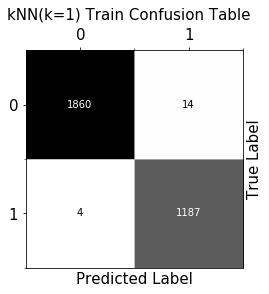

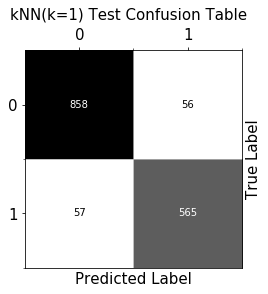

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 2) <<<<<<<
TRAIN ACCURACY: 96.77% | TEST ACCURACY: 91.80%
TRAIN ERROR RATE: 3.23% | TEST ERROR RATE: 8.20%
TRAIN FALSE NEGATIVES ERROR RATE: 3.13% | TEST FALSE NEGATIVES ERROR RATE: 6.97%
TRAIN FALSE POSITIVES ERROR RATE: 0.10% | TEST FALSE POSITIVES ERROR RATE: 1.24%
---------------------------------------------------------------------------------------


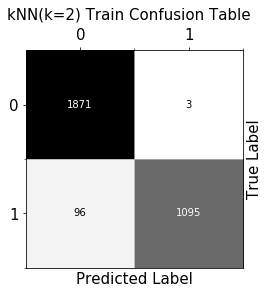

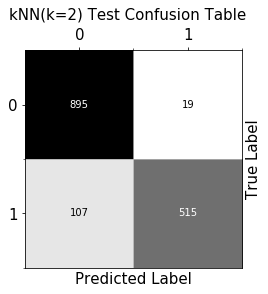

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 3) <<<<<<<
TRAIN ACCURACY: 96.31% | TEST ACCURACY: 93.29%
TRAIN ERROR RATE: 3.69% | TEST ERROR RATE: 6.71%
TRAIN FALSE NEGATIVES ERROR RATE: 1.99% | TEST FALSE NEGATIVES ERROR RATE: 4.17%
TRAIN FALSE POSITIVES ERROR RATE: 1.70% | TEST FALSE POSITIVES ERROR RATE: 2.54%
---------------------------------------------------------------------------------------


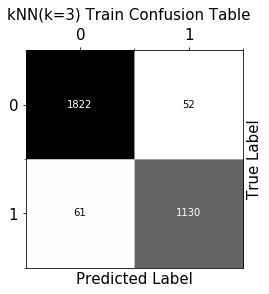

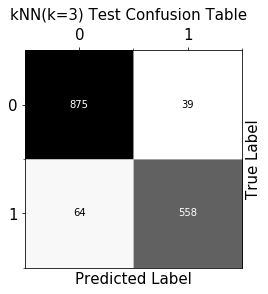

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 4) <<<<<<<
TRAIN ACCURACY: 95.30% | TEST ACCURACY: 92.19%
TRAIN ERROR RATE: 4.70% | TEST ERROR RATE: 7.81%
TRAIN FALSE NEGATIVES ERROR RATE: 3.62% | TEST FALSE NEGATIVES ERROR RATE: 6.38%
TRAIN FALSE POSITIVES ERROR RATE: 1.08% | TEST FALSE POSITIVES ERROR RATE: 1.43%
---------------------------------------------------------------------------------------


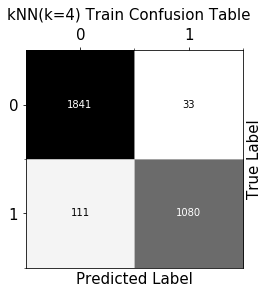

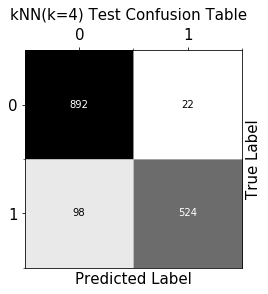

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 5) <<<<<<<
TRAIN ACCURACY: 95.76% | TEST ACCURACY: 93.82%
TRAIN ERROR RATE: 4.24% | TEST ERROR RATE: 6.18%
TRAIN FALSE NEGATIVES ERROR RATE: 2.61% | TEST FALSE NEGATIVES ERROR RATE: 4.10%
TRAIN FALSE POSITIVES ERROR RATE: 1.63% | TEST FALSE POSITIVES ERROR RATE: 2.08%
---------------------------------------------------------------------------------------


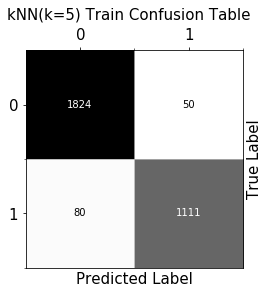

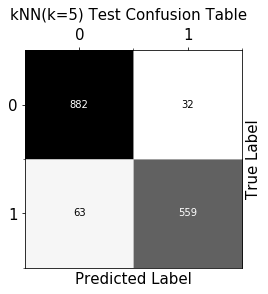

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 6) <<<<<<<
TRAIN ACCURACY: 95.17% | TEST ACCURACY: 92.19%
TRAIN ERROR RATE: 4.83% | TEST ERROR RATE: 7.81%
TRAIN FALSE NEGATIVES ERROR RATE: 3.59% | TEST FALSE NEGATIVES ERROR RATE: 6.25%
TRAIN FALSE POSITIVES ERROR RATE: 1.24% | TEST FALSE POSITIVES ERROR RATE: 1.56%
---------------------------------------------------------------------------------------


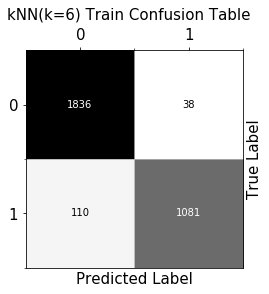

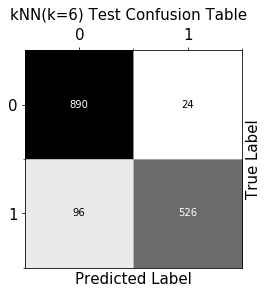

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 7) <<<<<<<
TRAIN ACCURACY: 95.66% | TEST ACCURACY: 92.64%
TRAIN ERROR RATE: 4.34% | TEST ERROR RATE: 7.36%
TRAIN FALSE NEGATIVES ERROR RATE: 2.54% | TEST FALSE NEGATIVES ERROR RATE: 5.14%
TRAIN FALSE POSITIVES ERROR RATE: 1.79% | TEST FALSE POSITIVES ERROR RATE: 2.21%
---------------------------------------------------------------------------------------


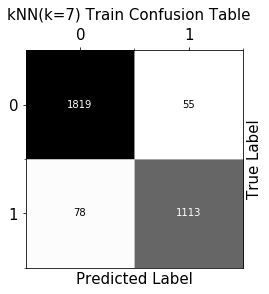

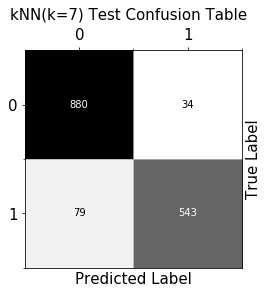

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 8) <<<<<<<
TRAIN ACCURACY: 95.27% | TEST ACCURACY: 92.45%
TRAIN ERROR RATE: 4.73% | TEST ERROR RATE: 7.55%
TRAIN FALSE NEGATIVES ERROR RATE: 3.36% | TEST FALSE NEGATIVES ERROR RATE: 5.79%
TRAIN FALSE POSITIVES ERROR RATE: 1.37% | TEST FALSE POSITIVES ERROR RATE: 1.76%
---------------------------------------------------------------------------------------


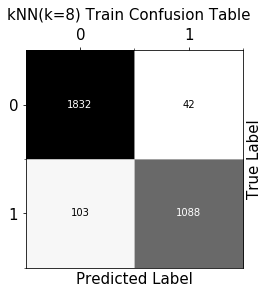

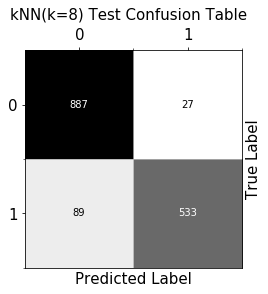

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 9) <<<<<<<
TRAIN ACCURACY: 95.20% | TEST ACCURACY: 93.16%
TRAIN ERROR RATE: 4.80% | TEST ERROR RATE: 6.84%
TRAIN FALSE NEGATIVES ERROR RATE: 2.68% | TEST FALSE NEGATIVES ERROR RATE: 4.75%
TRAIN FALSE POSITIVES ERROR RATE: 2.12% | TEST FALSE POSITIVES ERROR RATE: 2.08%
---------------------------------------------------------------------------------------


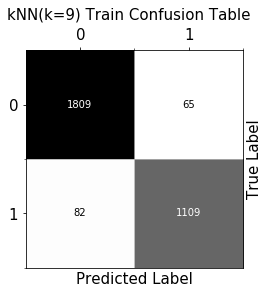

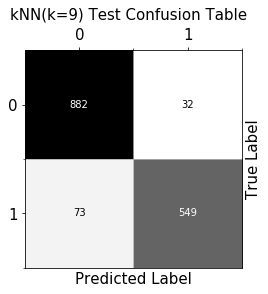

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 10) <<<<<<<
TRAIN ACCURACY: 94.78% | TEST ACCURACY: 92.25%
TRAIN ERROR RATE: 5.22% | TEST ERROR RATE: 7.75%
TRAIN FALSE NEGATIVES ERROR RATE: 3.39% | TEST FALSE NEGATIVES ERROR RATE: 5.99%
TRAIN FALSE POSITIVES ERROR RATE: 1.83% | TEST FALSE POSITIVES ERROR RATE: 1.76%
---------------------------------------------------------------------------------------


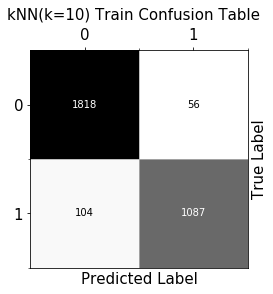

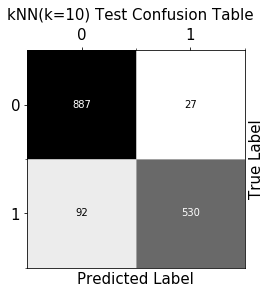

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 15) <<<<<<<
TRAIN ACCURACY: 94.45% | TEST ACCURACY: 92.45%
TRAIN ERROR RATE: 5.55% | TEST ERROR RATE: 7.55%
TRAIN FALSE NEGATIVES ERROR RATE: 3.23% | TEST FALSE NEGATIVES ERROR RATE: 5.14%
TRAIN FALSE POSITIVES ERROR RATE: 2.32% | TEST FALSE POSITIVES ERROR RATE: 2.41%
---------------------------------------------------------------------------------------


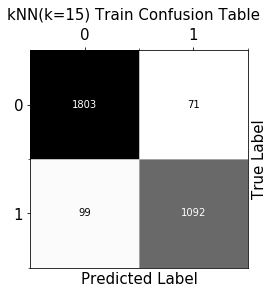

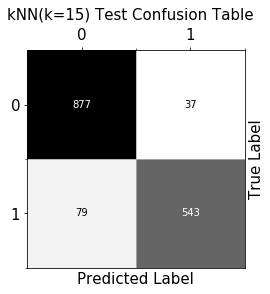

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 20) <<<<<<<
TRAIN ACCURACY: 93.96% | TEST ACCURACY: 92.06%
TRAIN ERROR RATE: 6.04% | TEST ERROR RATE: 7.94%
TRAIN FALSE NEGATIVES ERROR RATE: 3.78% | TEST FALSE NEGATIVES ERROR RATE: 5.60%
TRAIN FALSE POSITIVES ERROR RATE: 2.25% | TEST FALSE POSITIVES ERROR RATE: 2.34%
---------------------------------------------------------------------------------------


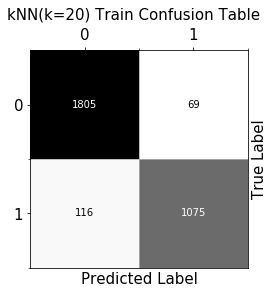

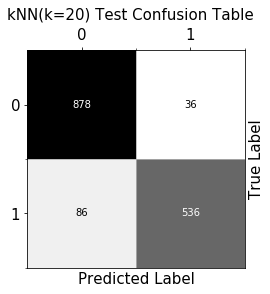

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 25) <<<<<<<
TRAIN ACCURACY: 93.83% | TEST ACCURACY: 91.93%
TRAIN ERROR RATE: 6.17% | TEST ERROR RATE: 8.07%
TRAIN FALSE NEGATIVES ERROR RATE: 3.75% | TEST FALSE NEGATIVES ERROR RATE: 5.60%
TRAIN FALSE POSITIVES ERROR RATE: 2.41% | TEST FALSE POSITIVES ERROR RATE: 2.47%
---------------------------------------------------------------------------------------


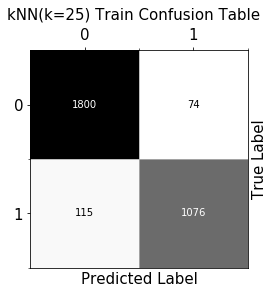

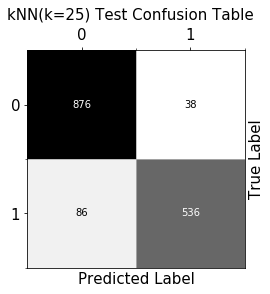

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 30) <<<<<<<
TRAIN ACCURACY: 93.34% | TEST ACCURACY: 91.80%
TRAIN ERROR RATE: 6.66% | TEST ERROR RATE: 8.20%
TRAIN FALSE NEGATIVES ERROR RATE: 4.34% | TEST FALSE NEGATIVES ERROR RATE: 5.86%
TRAIN FALSE POSITIVES ERROR RATE: 2.32% | TEST FALSE POSITIVES ERROR RATE: 2.34%
---------------------------------------------------------------------------------------


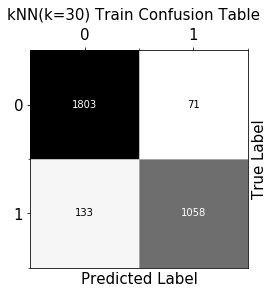

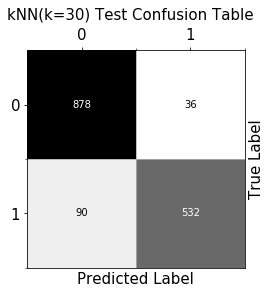

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 35) <<<<<<<
TRAIN ACCURACY: 92.95% | TEST ACCURACY: 91.73%
TRAIN ERROR RATE: 7.05% | TEST ERROR RATE: 8.27%
TRAIN FALSE NEGATIVES ERROR RATE: 4.50% | TEST FALSE NEGATIVES ERROR RATE: 5.86%
TRAIN FALSE POSITIVES ERROR RATE: 2.54% | TEST FALSE POSITIVES ERROR RATE: 2.41%
---------------------------------------------------------------------------------------


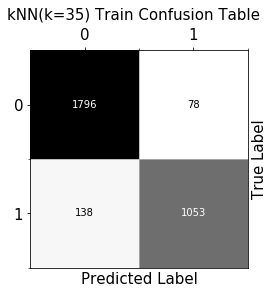

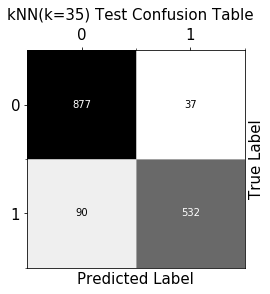

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 40) <<<<<<<
TRAIN ACCURACY: 92.50% | TEST ACCURACY: 91.28%
TRAIN ERROR RATE: 7.50% | TEST ERROR RATE: 8.72%
TRAIN FALSE NEGATIVES ERROR RATE: 4.89% | TEST FALSE NEGATIVES ERROR RATE: 6.45%
TRAIN FALSE POSITIVES ERROR RATE: 2.61% | TEST FALSE POSITIVES ERROR RATE: 2.28%
---------------------------------------------------------------------------------------


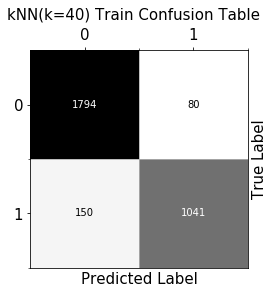

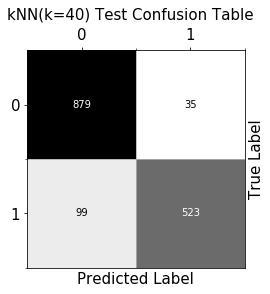

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 45) <<<<<<<
TRAIN ACCURACY: 92.20% | TEST ACCURACY: 91.15%
TRAIN ERROR RATE: 7.80% | TEST ERROR RATE: 8.85%
TRAIN FALSE NEGATIVES ERROR RATE: 4.96% | TEST FALSE NEGATIVES ERROR RATE: 6.58%
TRAIN FALSE POSITIVES ERROR RATE: 2.84% | TEST FALSE POSITIVES ERROR RATE: 2.28%
---------------------------------------------------------------------------------------


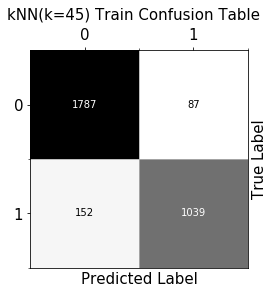

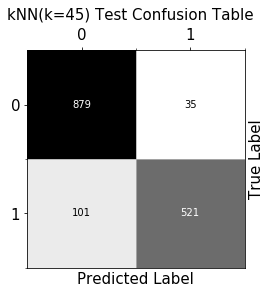

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 50) <<<<<<<
TRAIN ACCURACY: 91.91% | TEST ACCURACY: 90.56%
TRAIN ERROR RATE: 8.09% | TEST ERROR RATE: 9.44%
TRAIN FALSE NEGATIVES ERROR RATE: 5.42% | TEST FALSE NEGATIVES ERROR RATE: 7.16%
TRAIN FALSE POSITIVES ERROR RATE: 2.68% | TEST FALSE POSITIVES ERROR RATE: 2.28%
---------------------------------------------------------------------------------------


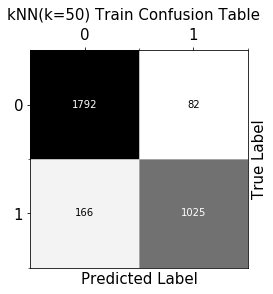

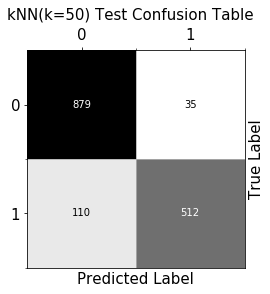

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 55) <<<<<<<
TRAIN ACCURACY: 91.88% | TEST ACCURACY: 90.36%
TRAIN ERROR RATE: 8.12% | TEST ERROR RATE: 9.64%
TRAIN FALSE NEGATIVES ERROR RATE: 5.45% | TEST FALSE NEGATIVES ERROR RATE: 7.03%
TRAIN FALSE POSITIVES ERROR RATE: 2.68% | TEST FALSE POSITIVES ERROR RATE: 2.60%
---------------------------------------------------------------------------------------


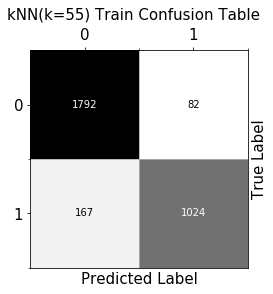

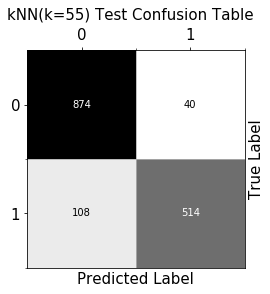

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 60) <<<<<<<
TRAIN ACCURACY: 91.81% | TEST ACCURACY: 90.17%
TRAIN ERROR RATE: 8.19% | TEST ERROR RATE: 9.83%
TRAIN FALSE NEGATIVES ERROR RATE: 5.55% | TEST FALSE NEGATIVES ERROR RATE: 7.42%
TRAIN FALSE POSITIVES ERROR RATE: 2.64% | TEST FALSE POSITIVES ERROR RATE: 2.41%
---------------------------------------------------------------------------------------


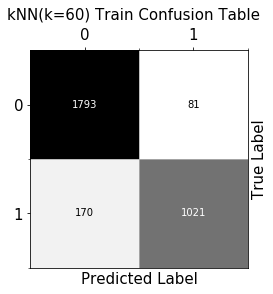

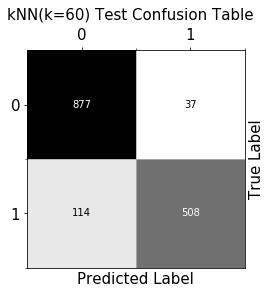

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 65) <<<<<<<
TRAIN ACCURACY: 91.35% | TEST ACCURACY: 89.78%
TRAIN ERROR RATE: 8.65% | TEST ERROR RATE: 10.22%
TRAIN FALSE NEGATIVES ERROR RATE: 5.68% | TEST FALSE NEGATIVES ERROR RATE: 7.36%
TRAIN FALSE POSITIVES ERROR RATE: 2.97% | TEST FALSE POSITIVES ERROR RATE: 2.86%
---------------------------------------------------------------------------------------


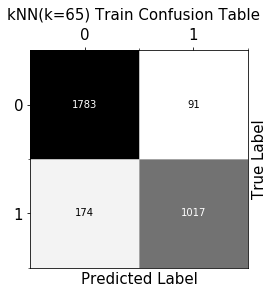

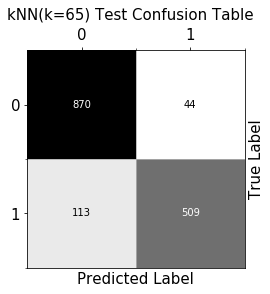

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 70) <<<<<<<
TRAIN ACCURACY: 91.03% | TEST ACCURACY: 89.71%
TRAIN ERROR RATE: 8.97% | TEST ERROR RATE: 10.29%
TRAIN FALSE NEGATIVES ERROR RATE: 5.97% | TEST FALSE NEGATIVES ERROR RATE: 7.62%
TRAIN FALSE POSITIVES ERROR RATE: 3.00% | TEST FALSE POSITIVES ERROR RATE: 2.67%
---------------------------------------------------------------------------------------


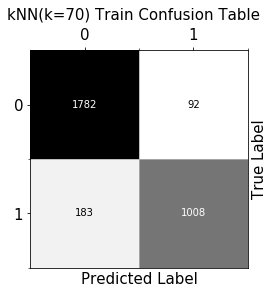

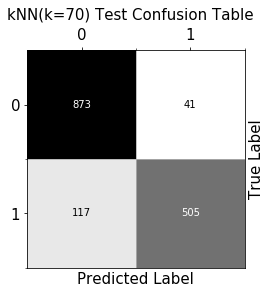

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 75) <<<<<<<
TRAIN ACCURACY: 91.19% | TEST ACCURACY: 89.65%
TRAIN ERROR RATE: 8.81% | TEST ERROR RATE: 10.35%
TRAIN FALSE NEGATIVES ERROR RATE: 5.87% | TEST FALSE NEGATIVES ERROR RATE: 7.49%
TRAIN FALSE POSITIVES ERROR RATE: 2.94% | TEST FALSE POSITIVES ERROR RATE: 2.86%
---------------------------------------------------------------------------------------


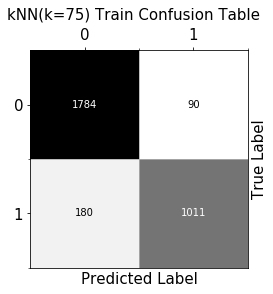

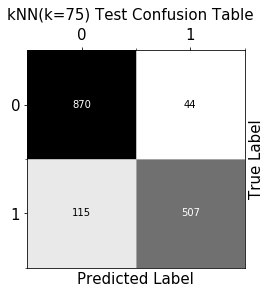

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 80) <<<<<<<
TRAIN ACCURACY: 91.09% | TEST ACCURACY: 89.58%
TRAIN ERROR RATE: 8.91% | TEST ERROR RATE: 10.42%
TRAIN FALSE NEGATIVES ERROR RATE: 6.04% | TEST FALSE NEGATIVES ERROR RATE: 7.62%
TRAIN FALSE POSITIVES ERROR RATE: 2.87% | TEST FALSE POSITIVES ERROR RATE: 2.80%
---------------------------------------------------------------------------------------


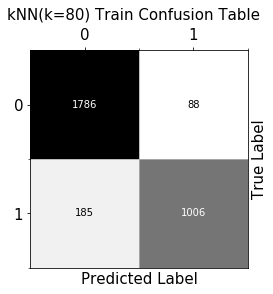

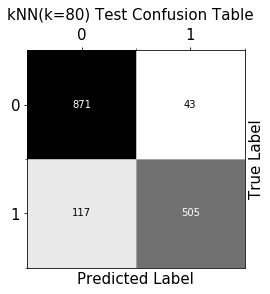

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 85) <<<<<<<
TRAIN ACCURACY: 91.06% | TEST ACCURACY: 89.52%
TRAIN ERROR RATE: 8.94% | TEST ERROR RATE: 10.48%
TRAIN FALSE NEGATIVES ERROR RATE: 6.00% | TEST FALSE NEGATIVES ERROR RATE: 7.62%
TRAIN FALSE POSITIVES ERROR RATE: 2.94% | TEST FALSE POSITIVES ERROR RATE: 2.86%
---------------------------------------------------------------------------------------


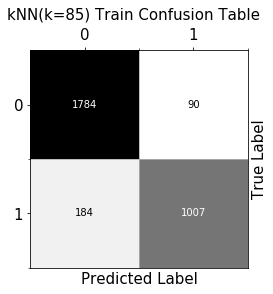

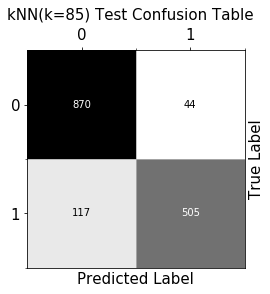

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 90) <<<<<<<
TRAIN ACCURACY: 90.86% | TEST ACCURACY: 89.39%
TRAIN ERROR RATE: 9.14% | TEST ERROR RATE: 10.61%
TRAIN FALSE NEGATIVES ERROR RATE: 6.23% | TEST FALSE NEGATIVES ERROR RATE: 7.75%
TRAIN FALSE POSITIVES ERROR RATE: 2.90% | TEST FALSE POSITIVES ERROR RATE: 2.86%
---------------------------------------------------------------------------------------


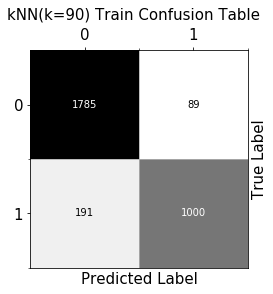

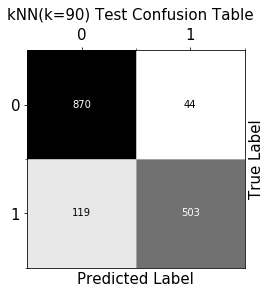

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 95) <<<<<<<
TRAIN ACCURACY: 91.03% | TEST ACCURACY: 89.45%
TRAIN ERROR RATE: 8.97% | TEST ERROR RATE: 10.55%
TRAIN FALSE NEGATIVES ERROR RATE: 6.00% | TEST FALSE NEGATIVES ERROR RATE: 7.81%
TRAIN FALSE POSITIVES ERROR RATE: 2.97% | TEST FALSE POSITIVES ERROR RATE: 2.73%
---------------------------------------------------------------------------------------


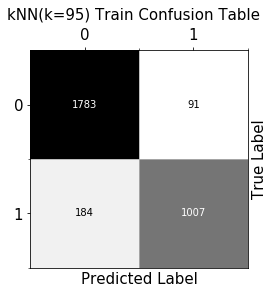

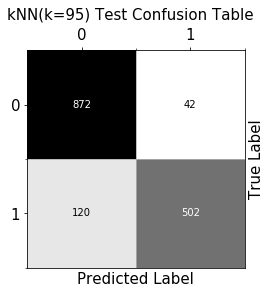

---------------------------------------------------------------------------------------
>>>>>>> kNN(K = 100) <<<<<<<
TRAIN ACCURACY: 90.80% | TEST ACCURACY: 89.65%
TRAIN ERROR RATE: 9.20% | TEST ERROR RATE: 10.35%
TRAIN FALSE NEGATIVES ERROR RATE: 6.33% | TEST FALSE NEGATIVES ERROR RATE: 7.75%
TRAIN FALSE POSITIVES ERROR RATE: 2.87% | TEST FALSE POSITIVES ERROR RATE: 2.60%
---------------------------------------------------------------------------------------


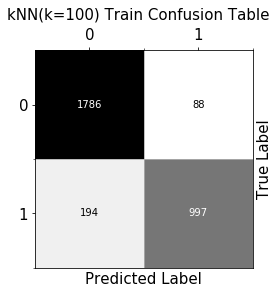

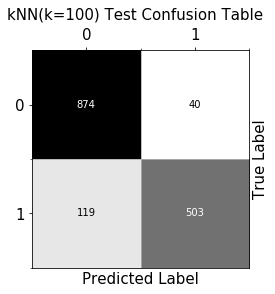

DATA FOR THE FIT:


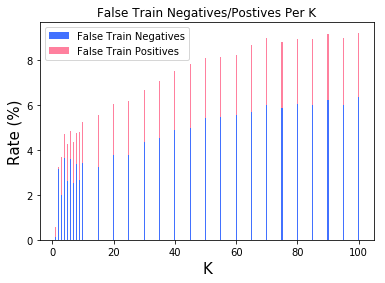

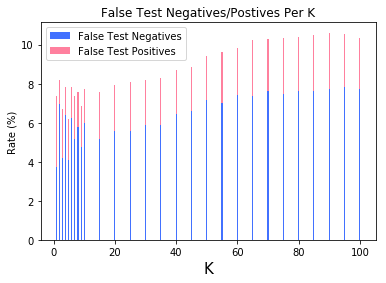

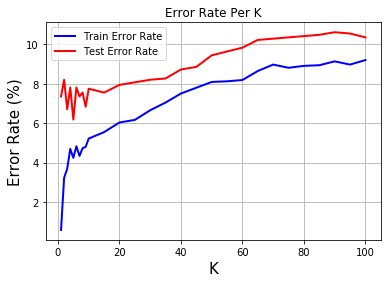

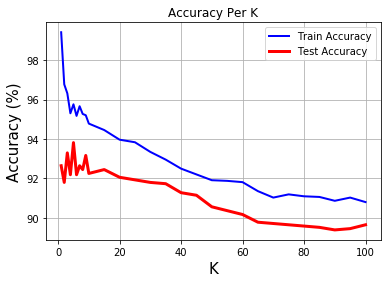

OVERALL TIME FOR FIT: 0.0h:0.0m:39.50826s
BEST PERFORMANCE ACHIEVED FOR: K = 5
TRAIN ACCURACY: 95.75856443719412% | TEST ACCURACY: 93.81510416666666%
TRAIN ERROR RATE: 4.24% | TEST ERROR RATE: 6.18%
TRAIN FALSE NEGATIVES ERROR RATE: 2.61% | TEST FALSE NEGATIVES ERROR RATE: 4.10%
TRAIN FALSE POSITIVES ERROR RATE: 1.63% | TEST FALSE POSITIVES ERROR RATE: 2.08%


In [47]:
# RUN
fit_KNN(K_values, X_TRAIN_LOG, T_TRAIN, X_TEST_LOG, T_TEST)